<a href="https://colab.research.google.com/github/ajeet966/Machinelearning/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Emotion Recognition**

In [1]:
import pandas as pd
import numpy as np

import os
import sys
import zipfile

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical # np_utils is deprecated, use to_categorical directly
from keras.callbacks import ModelCheckpoint
from google.colab import drive

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('/content/drive/MyDrive')  # Change to your specific directory


In [4]:
extracted_folder_path = '/content/drive/MyDrive/ExtractedFolder'
extracted_files = os.listdir(extracted_folder_path)
print(extracted_files)


['TESS Toronto emotional speech set data']


In [5]:
Tess = '/content/drive/MyDrive/ExtractedFolder/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/'

In [6]:
file_emotion = []
file_path = []

In [7]:
# List all directories in the TESS folder
tess_directory_list = os.listdir(Tess)

# Iterate over each directory
for dir in tess_directory_list:
    dir_path = os.path.join(Tess, dir)  # Get the full path of the directory
    if os.path.isdir(dir_path):  # Check if it's a directory
        # List all files in the directory
        directories = os.listdir(dir_path)
        for file in directories:
            file_path_full = os.path.join(dir_path, file)  # Full path to the file
            # Extract the emotion from the filename
            parts = file.split('.')[0].split('_')
            print(f"Filename: {file}, Parts: {parts}")  # Debugging line

            if len(parts) > 2:  # Ensure there are enough parts in the filename
                part = parts[2]
                if part == 'ps':
                    emotion = 'surprise'
                else:
                    emotion = part
                file_emotion.append(emotion)
                file_path.append(file_path_full)
            else:
                print(f"Skipping file with unexpected format: {file}")

# Create dataframes for emotions and file paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine the dataframes
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the dataframe
print(Tess_df.head(20))

Filename: OAF_back_angry.wav, Parts: ['OAF', 'back', 'angry']
Filename: OAF_bar_angry.wav, Parts: ['OAF', 'bar', 'angry']
Filename: OAF_base_angry.wav, Parts: ['OAF', 'base', 'angry']
Filename: OAF_bath_angry.wav, Parts: ['OAF', 'bath', 'angry']
Filename: OAF_bite_angry.wav, Parts: ['OAF', 'bite', 'angry']
Filename: OAF_beg_angry.wav, Parts: ['OAF', 'beg', 'angry']
Filename: OAF_bean_angry.wav, Parts: ['OAF', 'bean', 'angry']
Filename: OAF_book_angry.wav, Parts: ['OAF', 'book', 'angry']
Filename: OAF_bone_angry.wav, Parts: ['OAF', 'bone', 'angry']
Filename: OAF_boat_angry.wav, Parts: ['OAF', 'boat', 'angry']
Filename: OAF_bought_angry.wav, Parts: ['OAF', 'bought', 'angry']
Filename: OAF_cab_angry.wav, Parts: ['OAF', 'cab', 'angry']
Filename: OAF_burn_angry.wav, Parts: ['OAF', 'burn', 'angry']
Filename: OAF_cause_angry.wav, Parts: ['OAF', 'cause', 'angry']
Filename: OAF_calm_angry.wav, Parts: ['OAF', 'calm', 'angry']
Filename: OAF_came_angry.wav, Parts: ['OAF', 'came', 'angry']
Filename

In [8]:
# Assuming Tess_df are already defined
data_path = pd.concat([ Tess_df], axis=0)

# Save the combined DataFrame to a CSV file
data_path.to_csv("data_path.csv", index=False)

# Display the first few rows of the combined DataFrame
print(data_path.head())

  Emotions                                               Path
0    angry  /content/drive/MyDrive/ExtractedFolder/TESS To...
1    angry  /content/drive/MyDrive/ExtractedFolder/TESS To...
2    angry  /content/drive/MyDrive/ExtractedFolder/TESS To...
3    angry  /content/drive/MyDrive/ExtractedFolder/TESS To...
4    angry  /content/drive/MyDrive/ExtractedFolder/TESS To...


In [9]:
# Check the structure of the combined DataFrame
print(data_path.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotions  2800 non-null   object
 1   Path      2800 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB
None


In [10]:
data_path.Emotions.value_counts()

Emotions
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64

In [11]:
data_path.Emotions.unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'surprise', 'sad'],
      dtype=object)

In [12]:
data_path.Emotions.describe()

count      2800
unique        7
top       angry
freq        400
Name: Emotions, dtype: object

<ipython-input-13-874cd00999d3>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_path, x='Emotions', palette=palette)
<ipython-input-13-874cd00999d3>:6: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.countplot(data=data_path, x='Emotions', palette=palette)


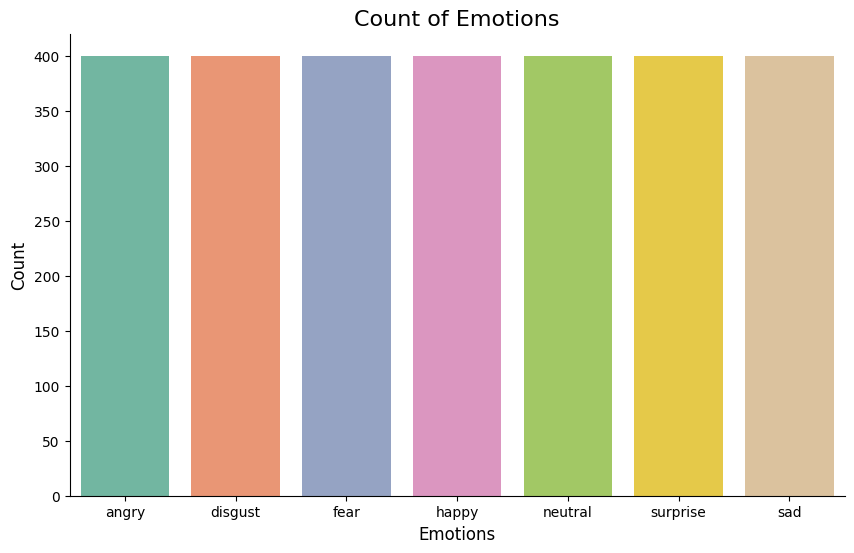

In [13]:
# Set a color palette for the countplot
palette = sns.color_palette("Set2")  # You can use other palettes or define your own colors

# Create the count plot
plt.figure(figsize=(10, 6))  # Optional: adjust figure size
sns.countplot(data=data_path, x='Emotions', palette=palette)

# Customize the plot
plt.title('Count of Emotions', size=16)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)

# Show the plot
plt.show()

In [14]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)
    D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def create_mel_spectrogram(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Mel Spectrogram for audio with {e} emotion', size=15)
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def create_chroma_features(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Chroma Features for audio with {emotion} emotion', size=15)
    chroma = librosa.feature.chroma_stft(y=data, sr=sr)
    librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
    plt.colorbar()
    plt.show()

def create_tonnetz(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Tonnetz for audio with {emotion} emotion', size=15)
    tonnetz = librosa.feature.tonnetz(y=data, sr=sr)
    librosa.display.specshow(tonnetz, x_axis='time')
    plt.colorbar()
    plt.show()

def create_frequency_histogram(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Frequency Histogram for audio with {e} emotion', size=15)
    spectrum = np.abs(librosa.stft(data))
    plt.hist(spectrum.flatten(), bins=100)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Count')
    plt.show()

def create_formant_frequencies(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Formant Frequencies for audio with {e} emotion', size=15)
    spectrum = np.abs(librosa.stft(data))
    mean_spectrum = np.mean(spectrum, axis=1)
    plt.plot(mean_spectrum)
    plt.title(f'Formant Frequencies for audio with {e} emotion')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.show()

def create_stft_plot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'STFT of audio with {e} emotion', size=15)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def create_temporal_envelope(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Temporal Envelope of audio with {e} emotion', size=15)
    plt.plot(np.linspace(0, len(data)/sr, num=len(data)), data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_cepstrum(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Cepstrum of audio with {e} emotion', size=15)
    ceps = librosa.feature.spectral_centroid(y=data, sr=sr)
    plt.plot(ceps.T)
    plt.xlabel('Time (s)')
    plt.ylabel('Cepstrum')
    plt.show()

def create_autocorrelation(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Autocorrelation of audio with {e} emotion', size=15)
    autocorr = librosa.autocorrelate(data)
    plt.plot(autocorr)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

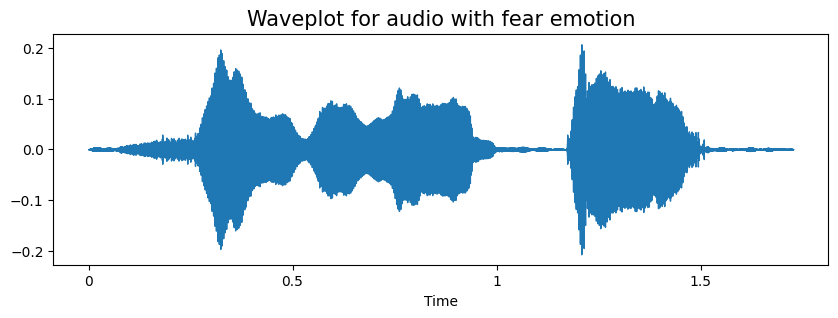

<ipython-input-14-e71bf04b4a12>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


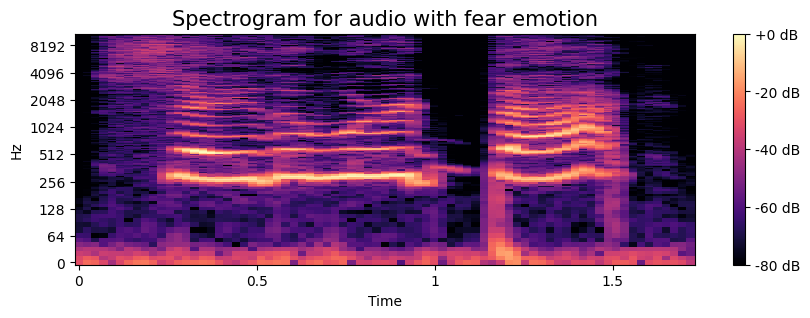

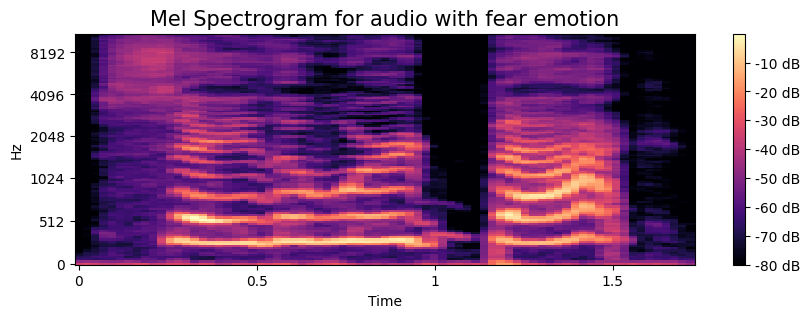

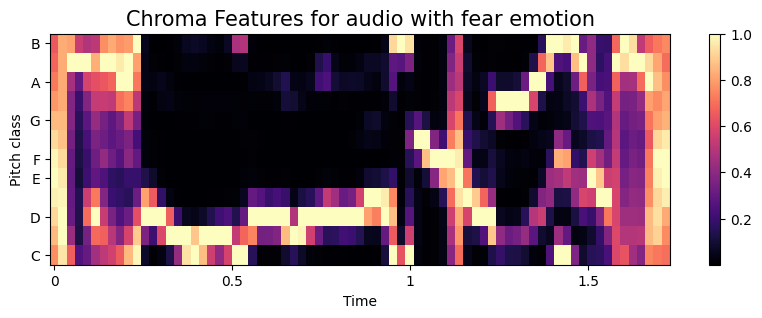

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=596
  warnings.warn(


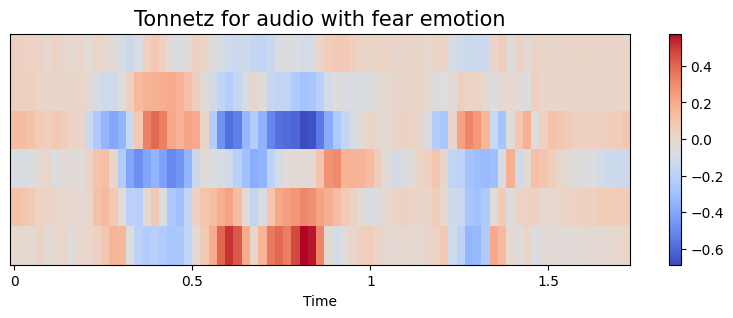

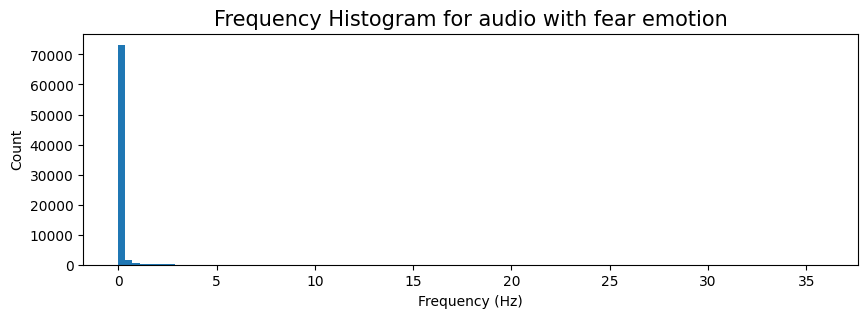

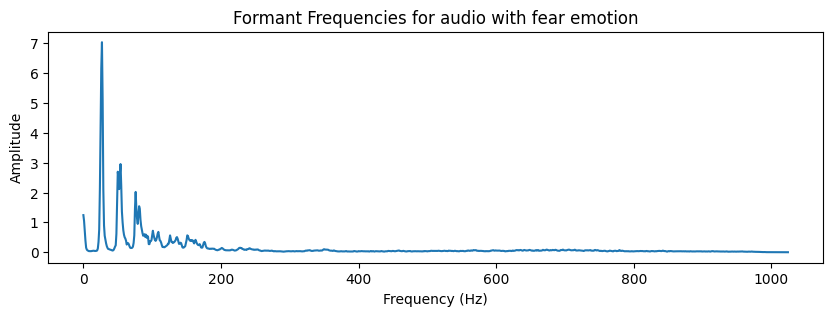

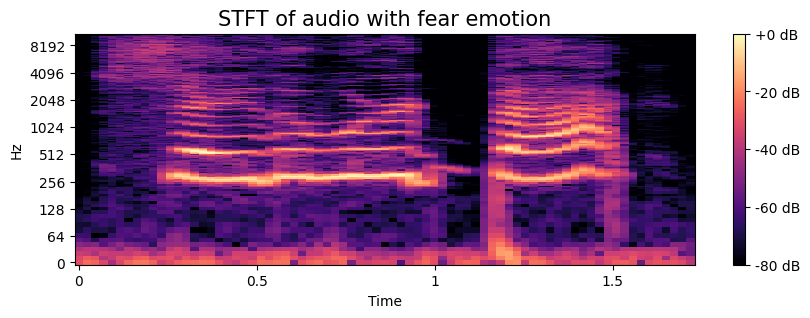

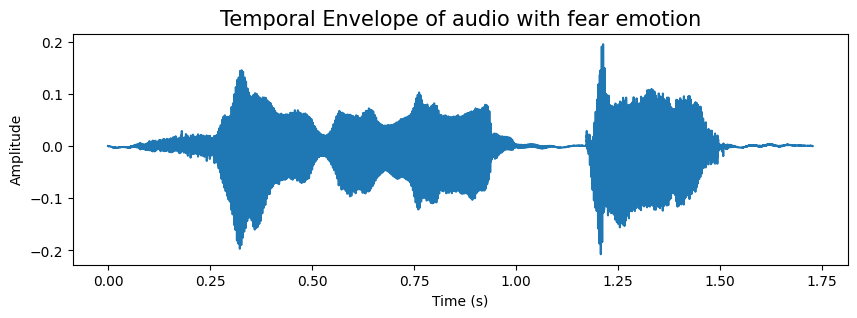

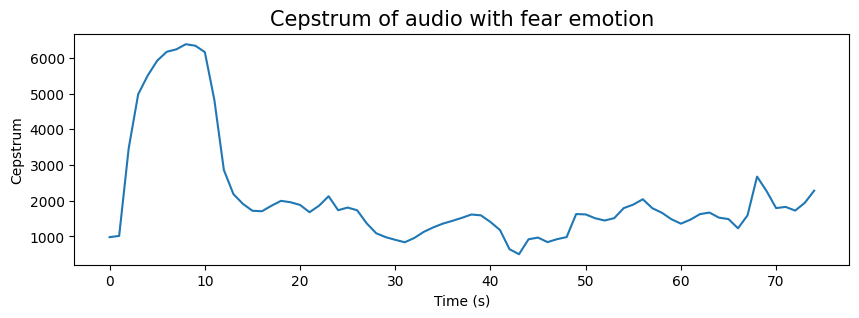

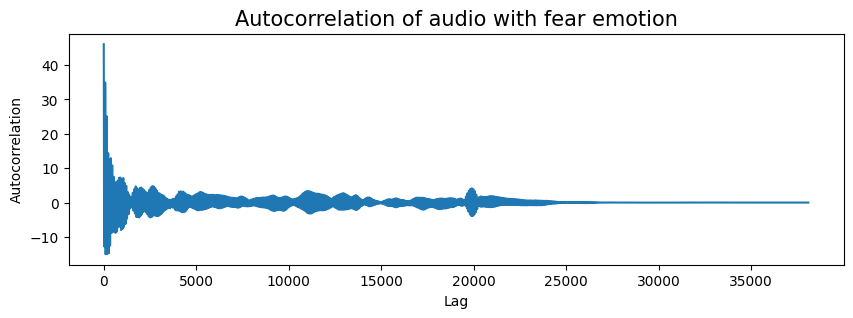

In [15]:
emotion = 'fear'  # Example emotion
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_chroma_features(data, sampling_rate, emotion)
create_tonnetz(data, sampling_rate, emotion)
create_frequency_histogram(data, sampling_rate, emotion)
create_formant_frequencies(data, sampling_rate, emotion)
create_stft_plot(data, sampling_rate, emotion)
create_temporal_envelope(data, sampling_rate, emotion)
create_cepstrum(data, sampling_rate, emotion)
create_autocorrelation(data, sampling_rate, emotion)
Audio(path)

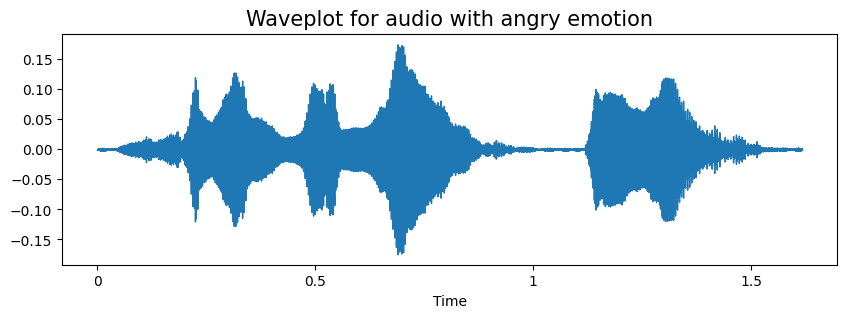

<ipython-input-14-e71bf04b4a12>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


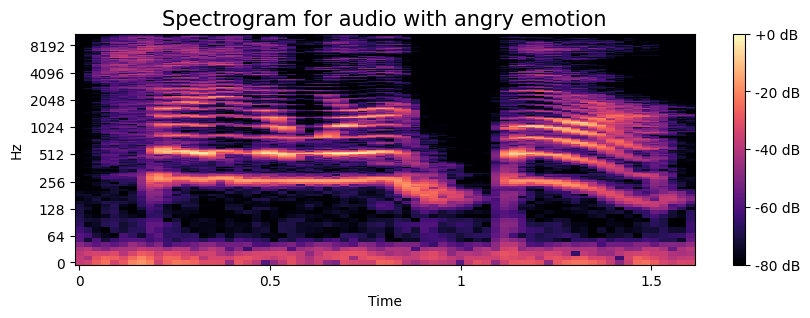

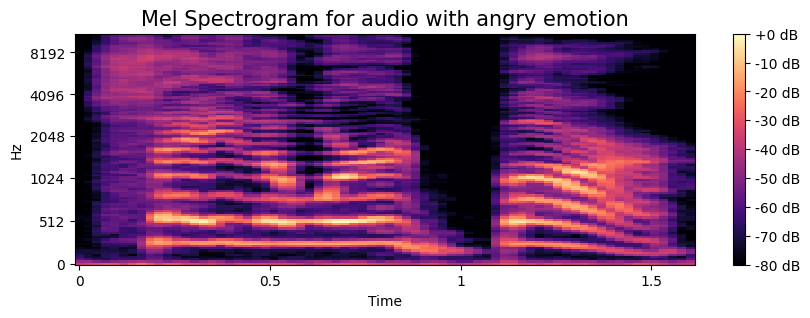

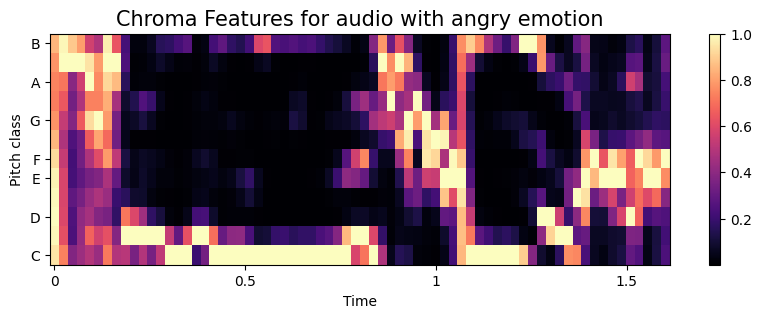

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=557
  warnings.warn(


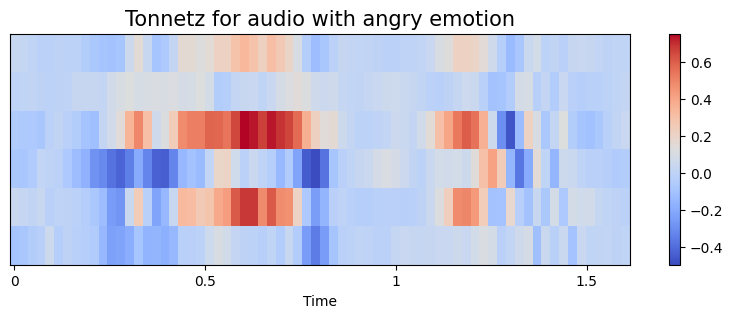

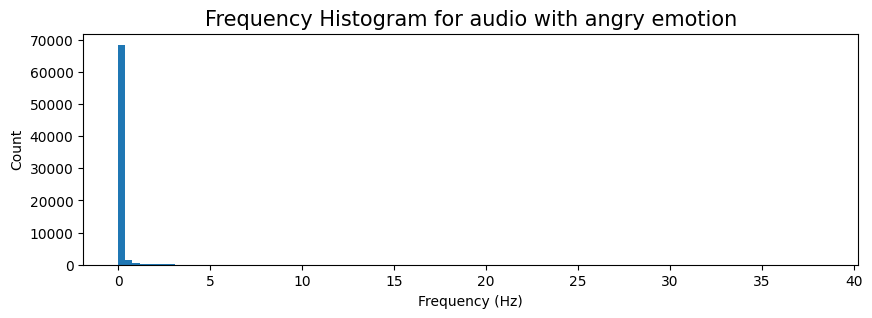

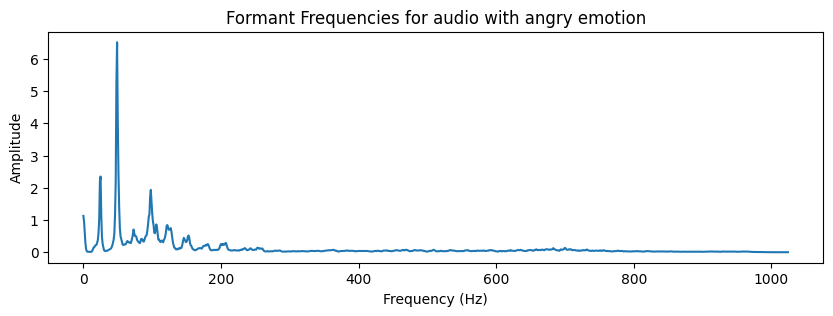

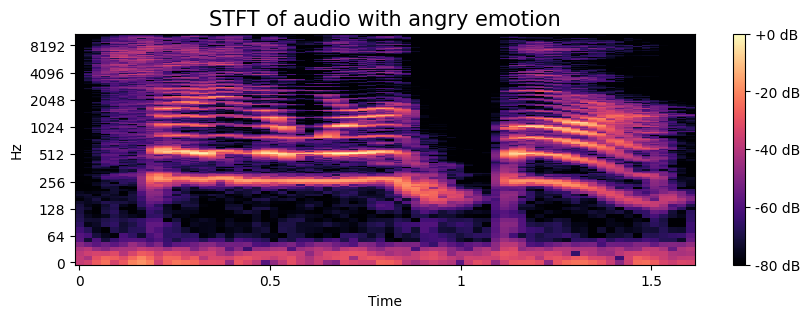

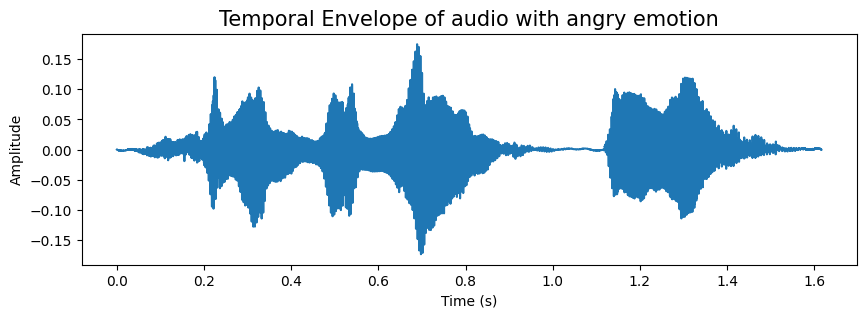

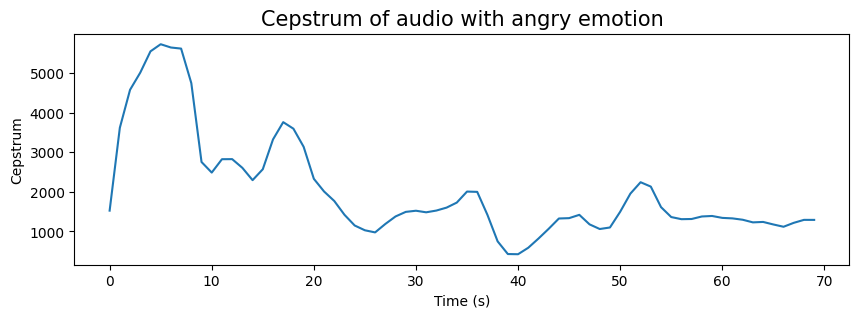

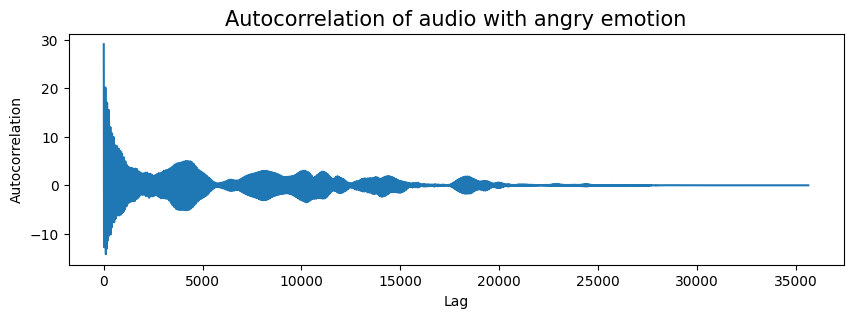

In [16]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_chroma_features(data, sampling_rate, emotion)
create_tonnetz(data, sampling_rate, emotion)
create_frequency_histogram(data, sampling_rate, emotion)
create_formant_frequencies(data, sampling_rate, emotion)
create_stft_plot(data, sampling_rate, emotion)
create_temporal_envelope(data, sampling_rate, emotion)
create_cepstrum(data, sampling_rate, emotion)
create_autocorrelation(data, sampling_rate, emotion)
Audio(path)

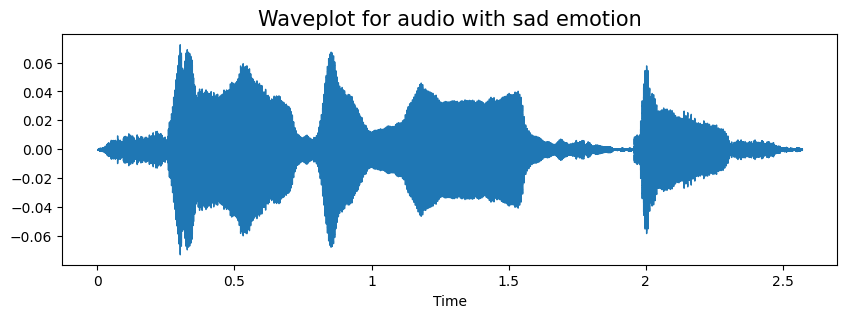

<ipython-input-14-e71bf04b4a12>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


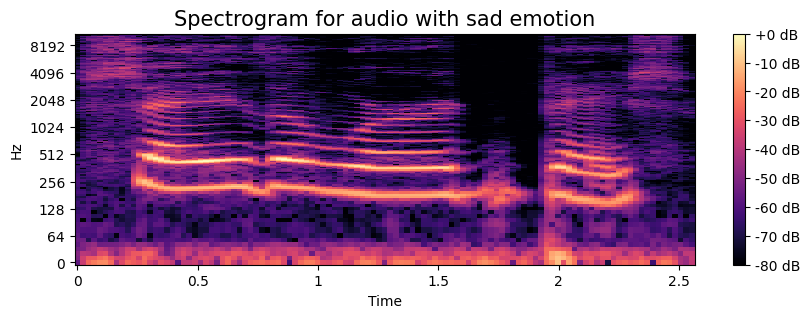

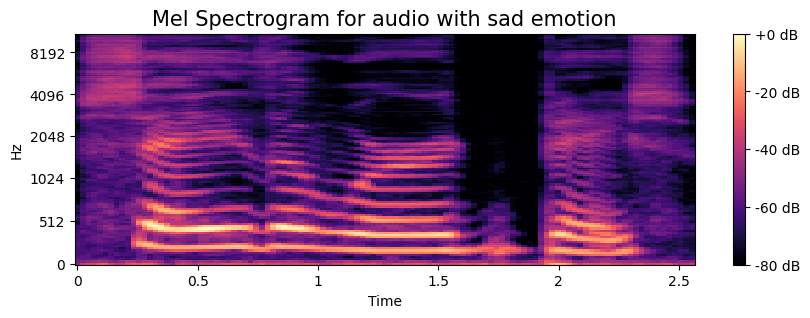

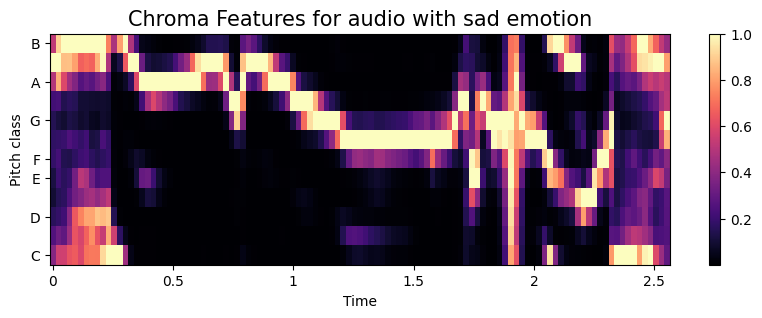

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=886
  warnings.warn(


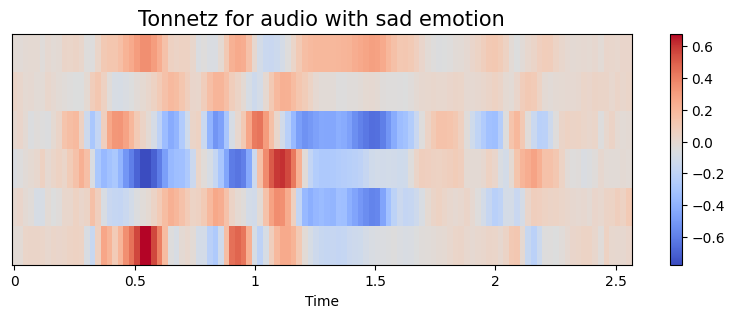

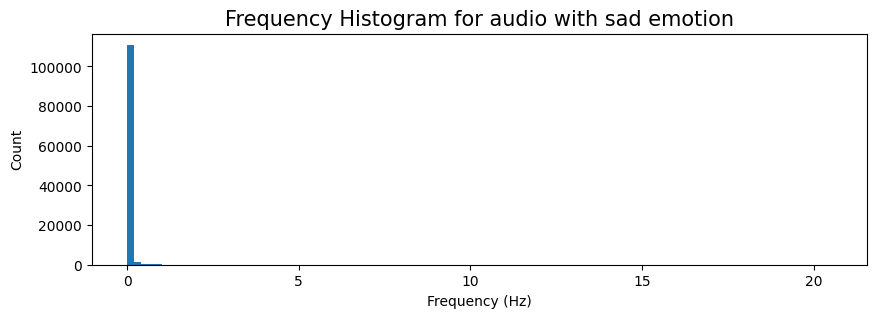

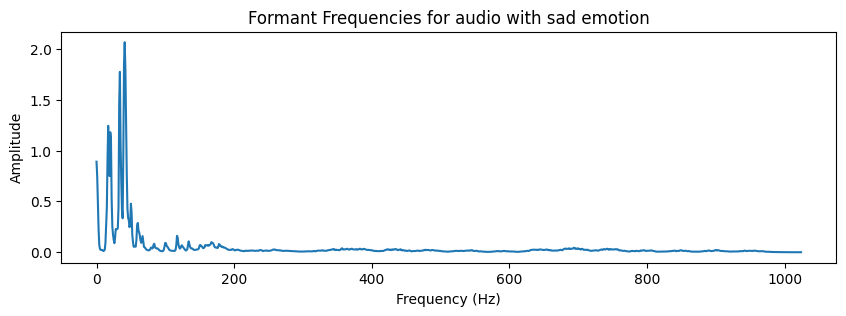

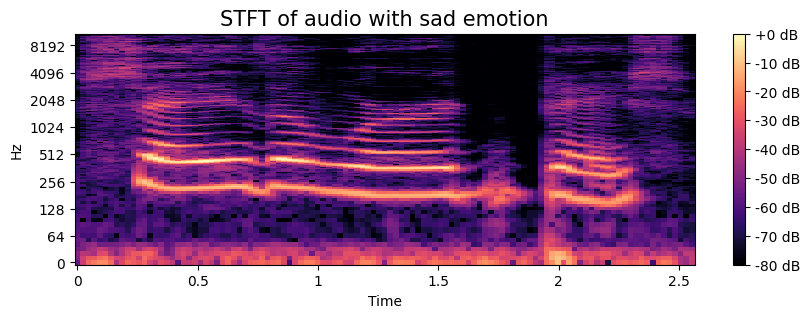

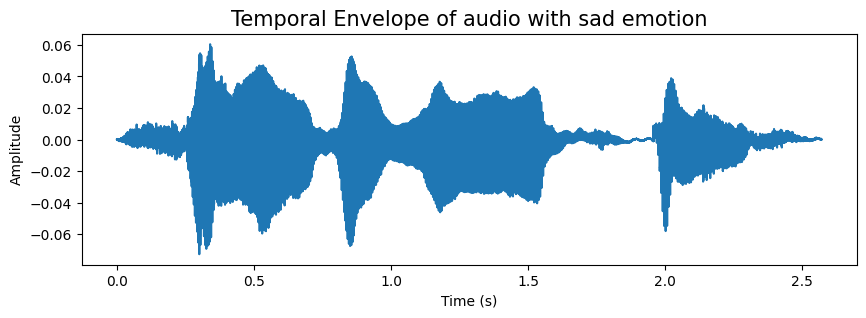

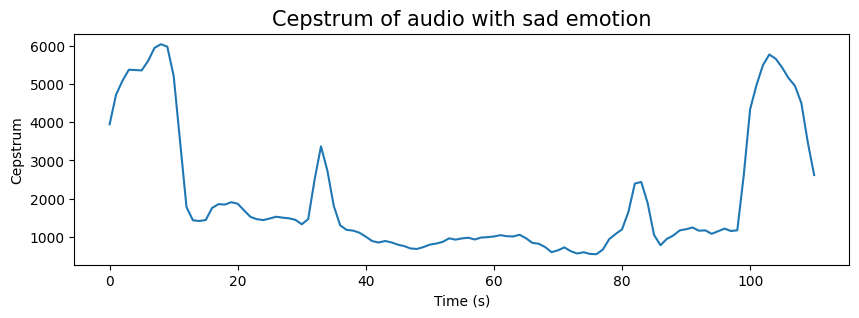

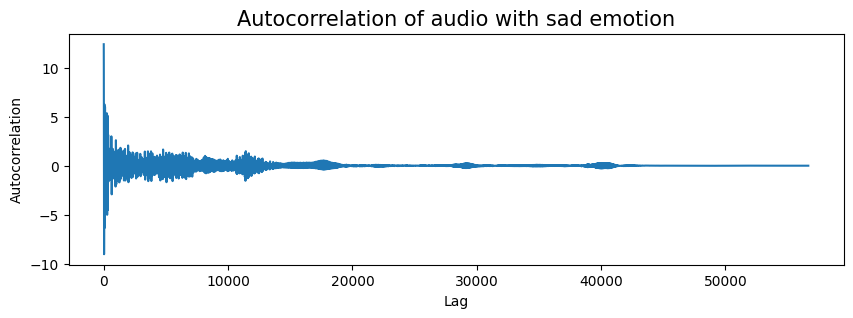

In [17]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_chroma_features(data, sampling_rate, emotion)
create_tonnetz(data, sampling_rate, emotion)
create_frequency_histogram(data, sampling_rate, emotion)
create_formant_frequencies(data, sampling_rate, emotion)
create_stft_plot(data, sampling_rate, emotion)
create_temporal_envelope(data, sampling_rate, emotion)
create_cepstrum(data, sampling_rate, emotion)
create_autocorrelation(data, sampling_rate, emotion)
Audio(path)

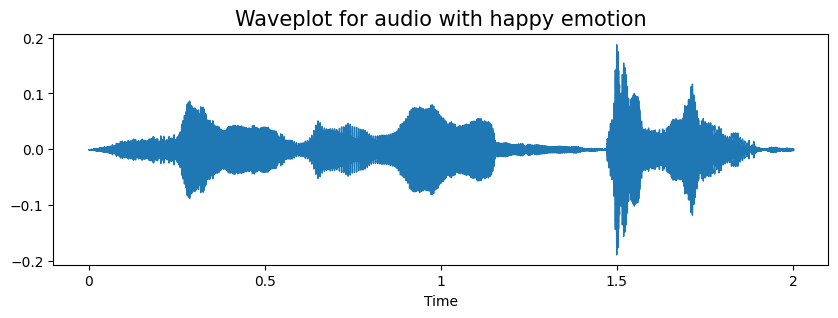

<ipython-input-14-e71bf04b4a12>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


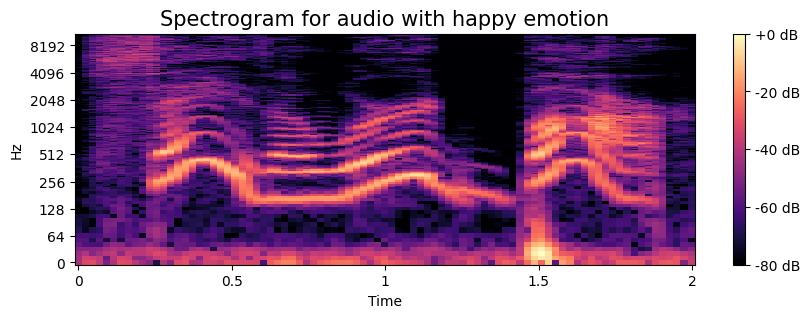

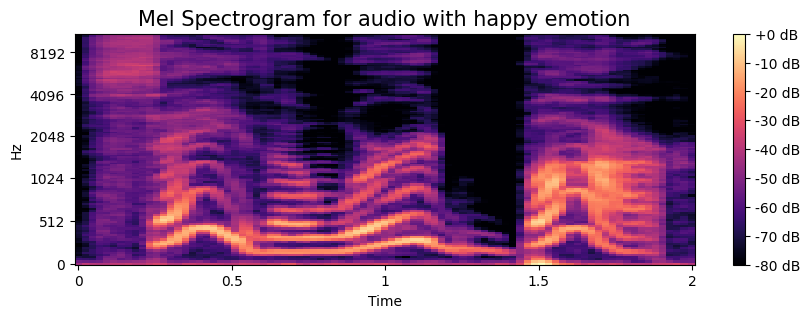

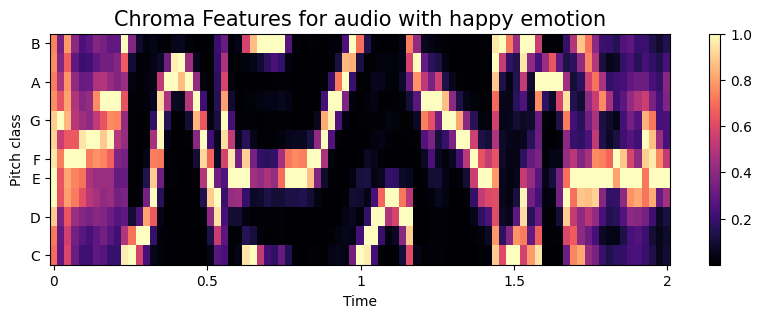

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


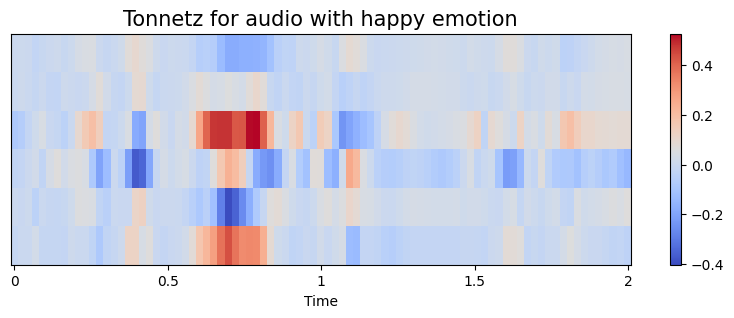

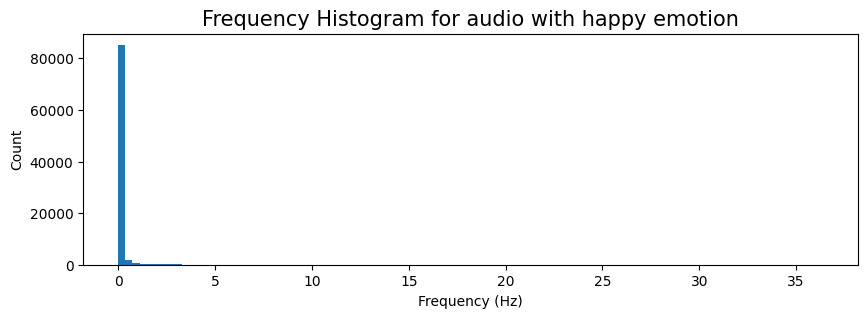

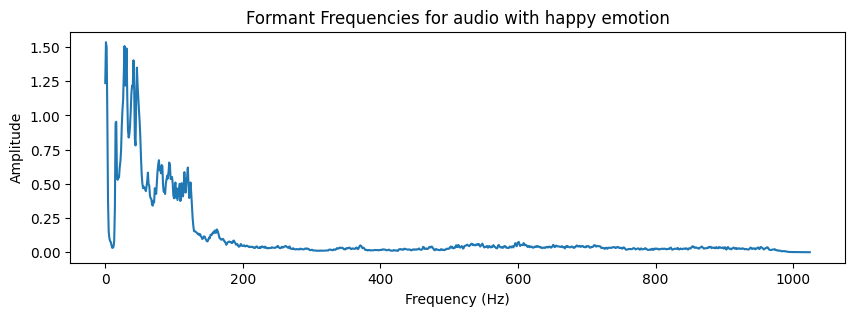

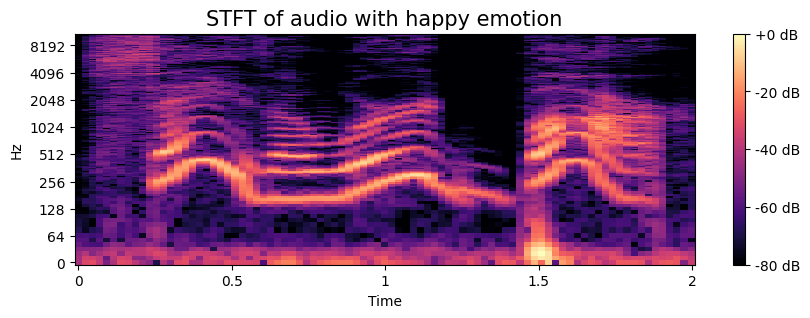

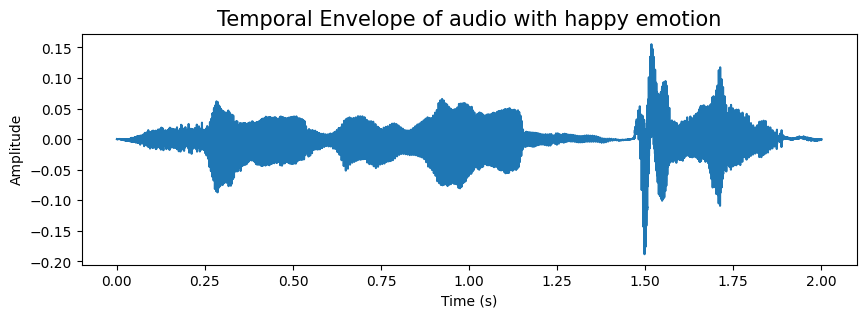

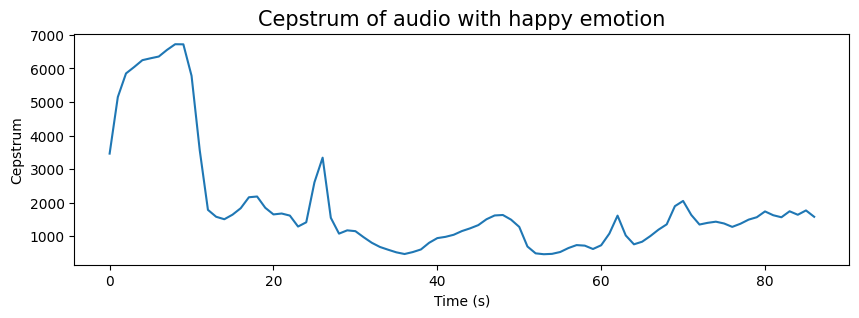

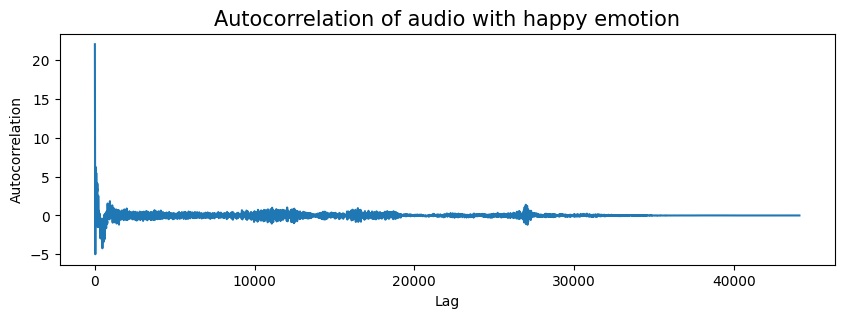

In [18]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_chroma_features(data, sampling_rate, emotion)
create_tonnetz(data, sampling_rate, emotion)
create_frequency_histogram(data, sampling_rate, emotion)
create_formant_frequencies(data, sampling_rate, emotion)
create_stft_plot(data, sampling_rate, emotion)
create_temporal_envelope(data, sampling_rate, emotion)
create_cepstrum(data, sampling_rate, emotion)
create_autocorrelation(data, sampling_rate, emotion)
Audio(path)

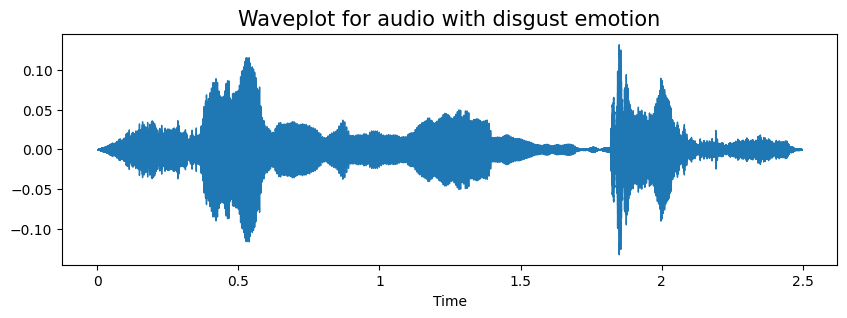

<ipython-input-14-e71bf04b4a12>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


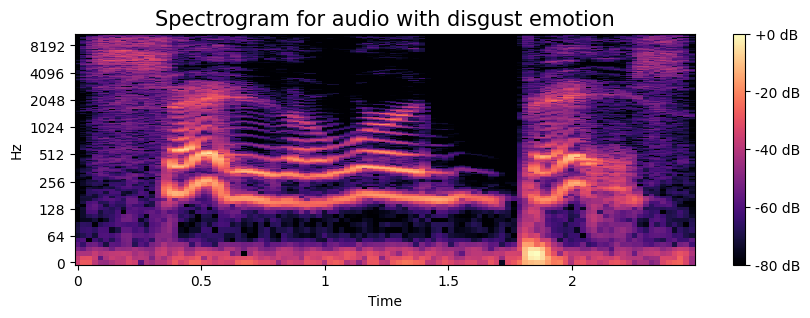

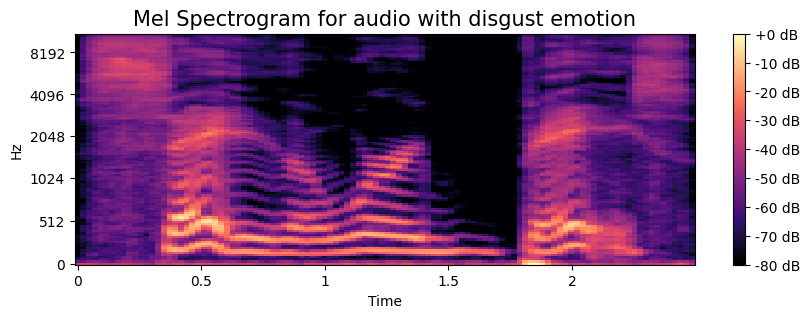

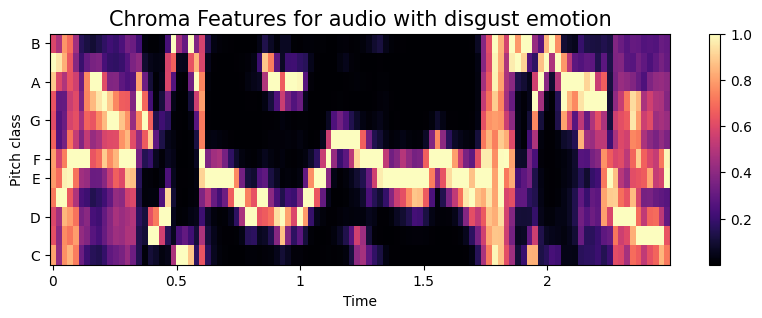

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=861
  warnings.warn(


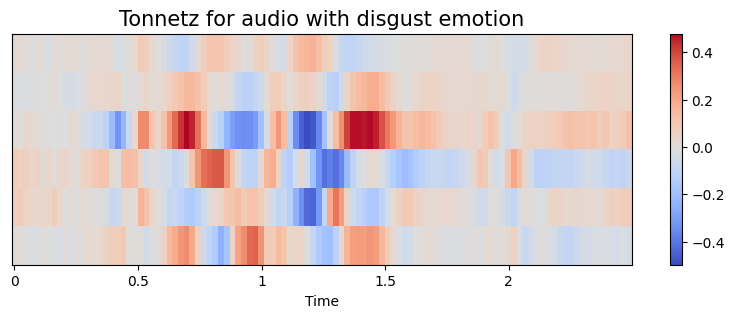

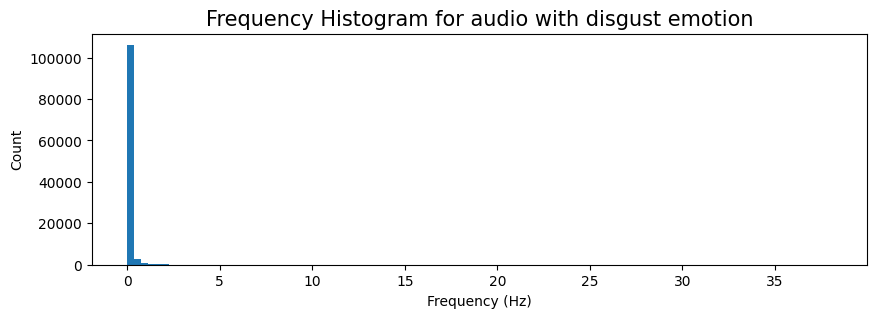

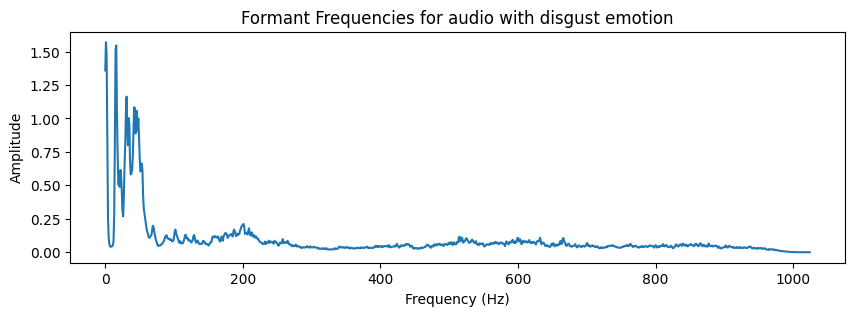

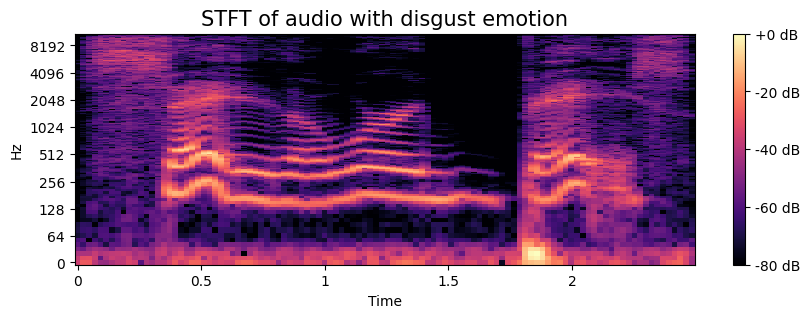

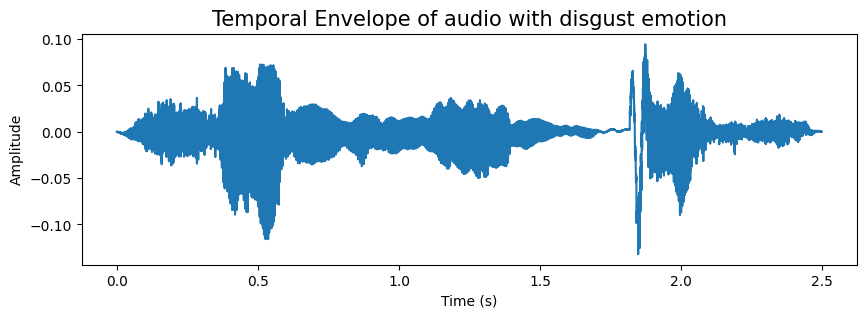

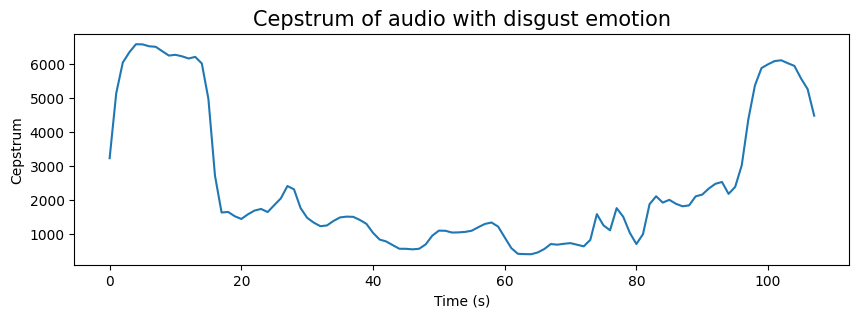

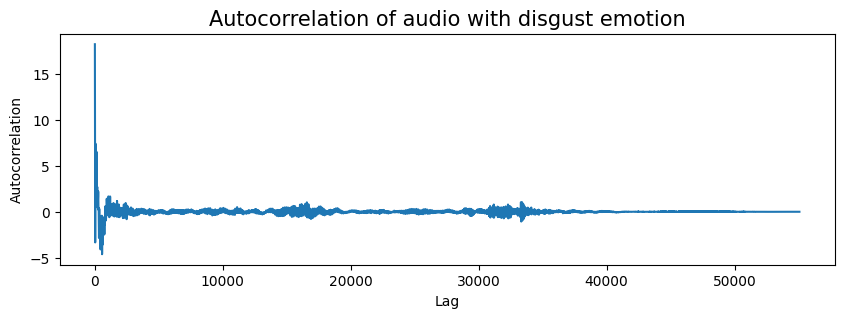

In [19]:
emotion='disgust'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_chroma_features(data, sampling_rate, emotion)
create_tonnetz(data, sampling_rate, emotion)
create_frequency_histogram(data, sampling_rate, emotion)
create_formant_frequencies(data, sampling_rate, emotion)
create_stft_plot(data, sampling_rate, emotion)
create_temporal_envelope(data, sampling_rate, emotion)
create_cepstrum(data, sampling_rate, emotion)
create_autocorrelation(data, sampling_rate, emotion)
Audio(path)

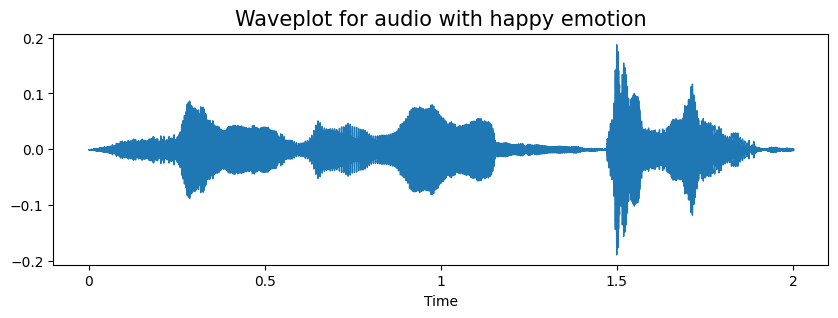

<ipython-input-14-e71bf04b4a12>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


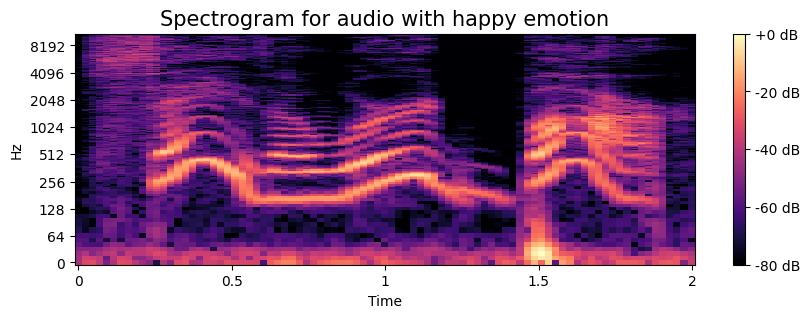

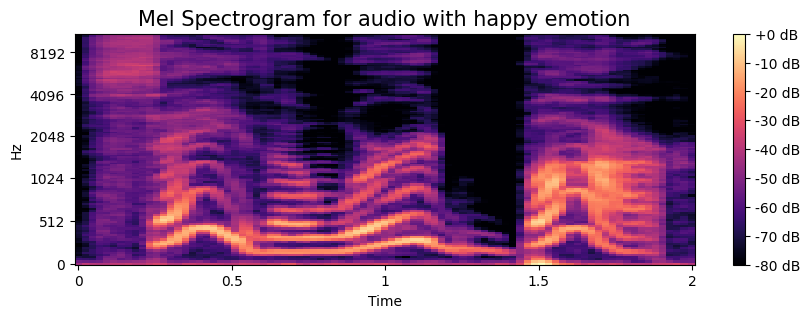

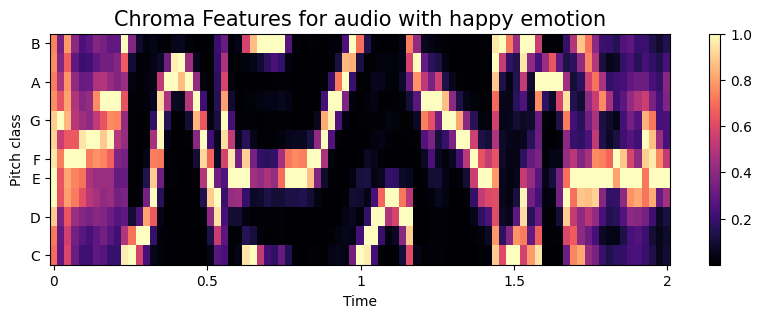

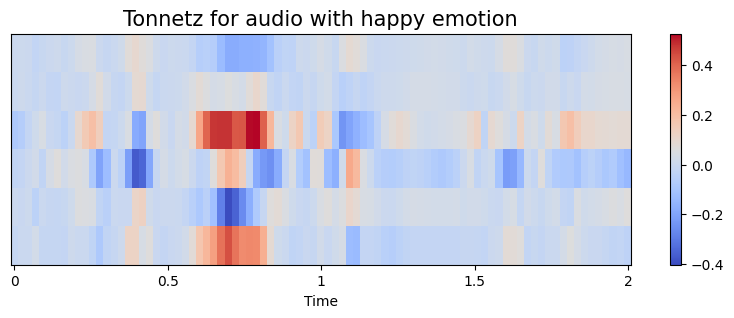

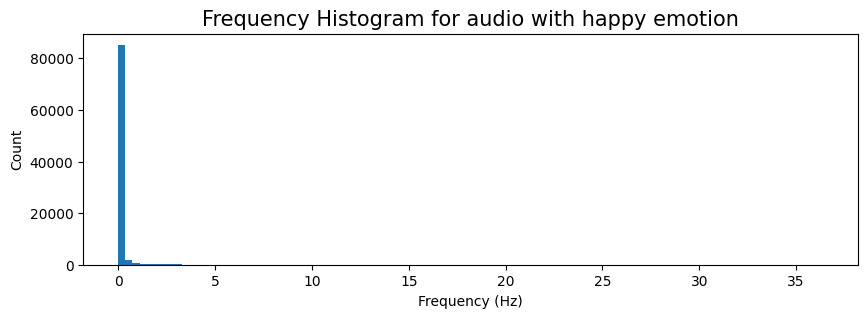

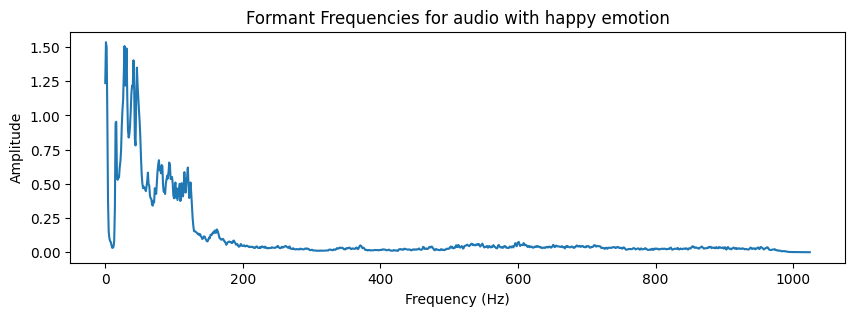

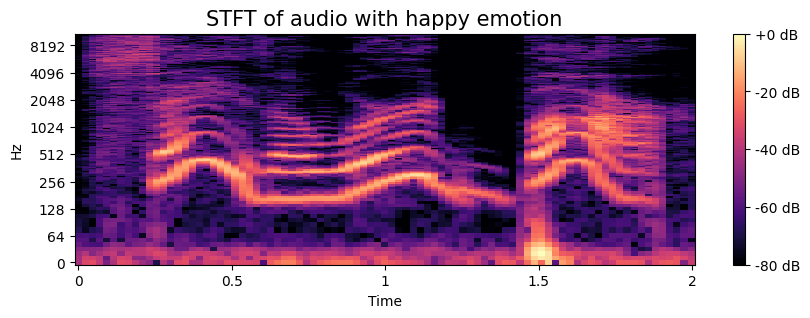

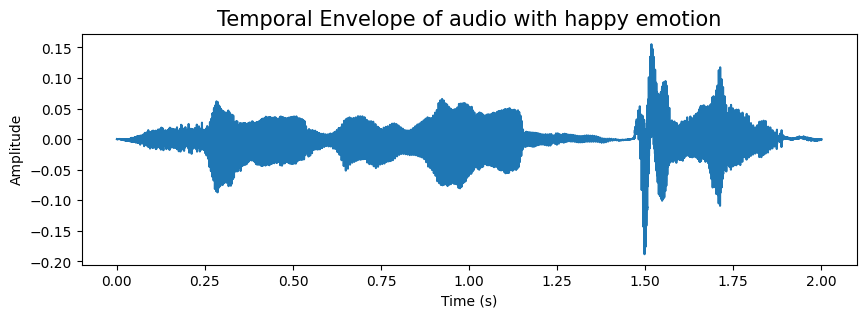

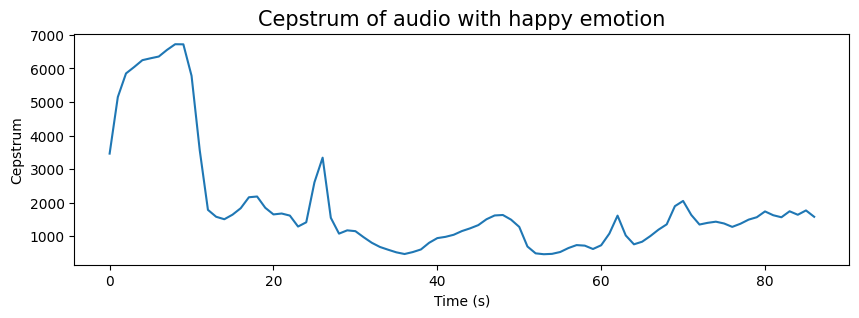

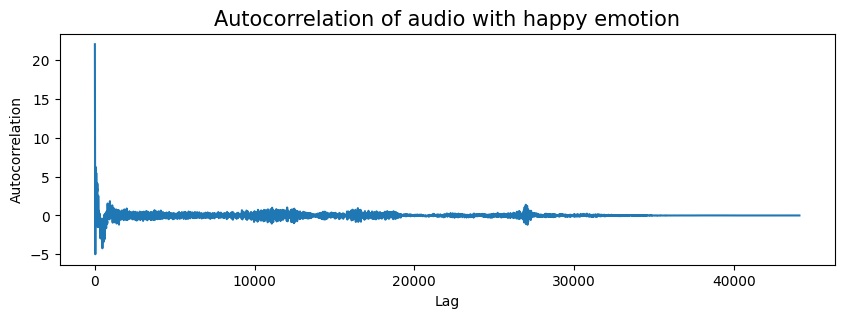

In [20]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_chroma_features(data, sampling_rate, emotion)
create_tonnetz(data, sampling_rate, emotion)
create_frequency_histogram(data, sampling_rate, emotion)
create_formant_frequencies(data, sampling_rate, emotion)
create_stft_plot(data, sampling_rate, emotion)
create_temporal_envelope(data, sampling_rate, emotion)
create_cepstrum(data, sampling_rate, emotion)
create_autocorrelation(data, sampling_rate, emotion)
Audio(path)

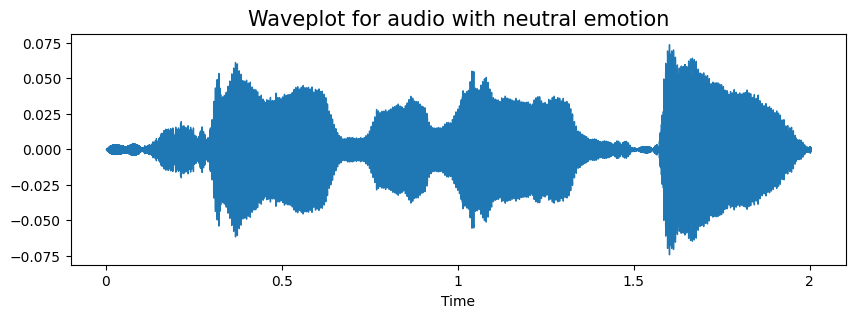

<ipython-input-14-e71bf04b4a12>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


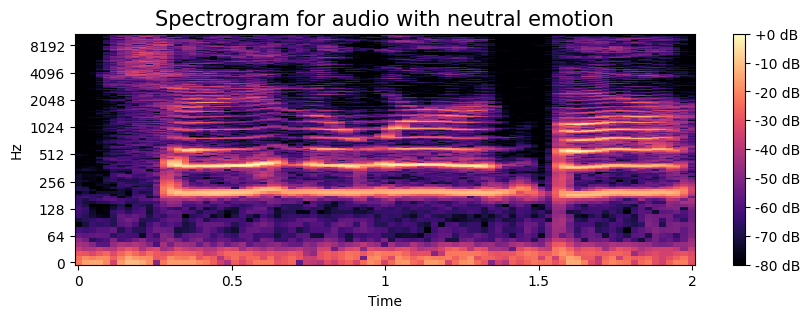

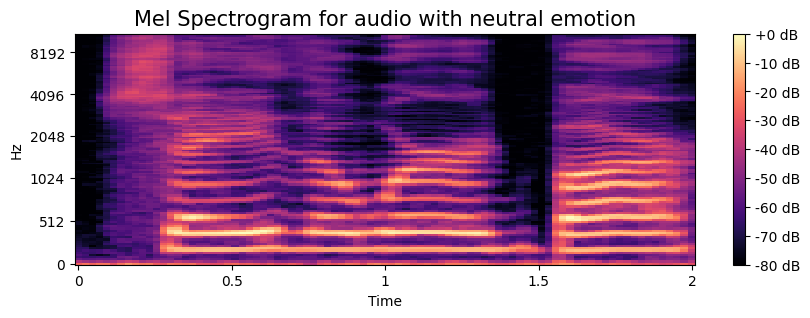

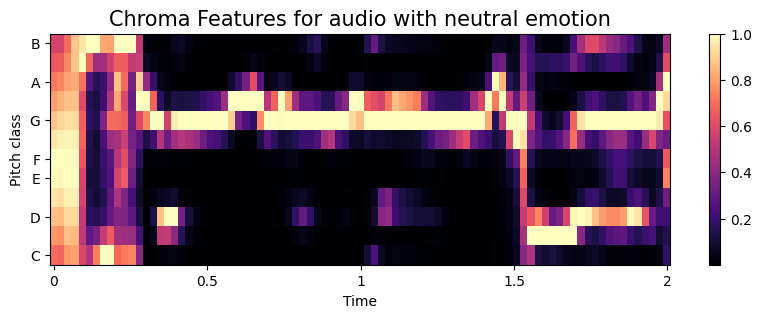

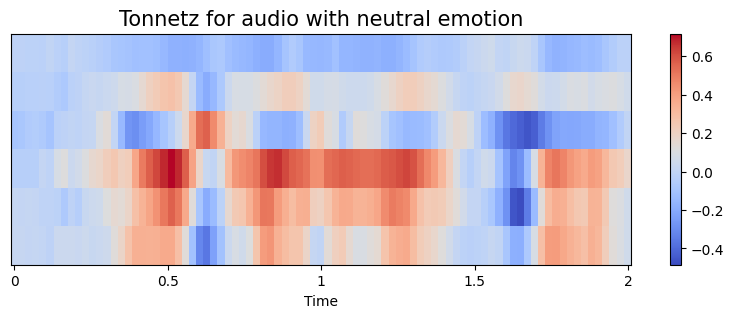

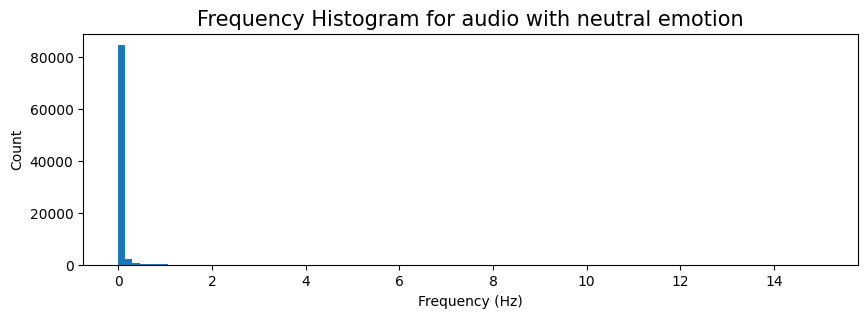

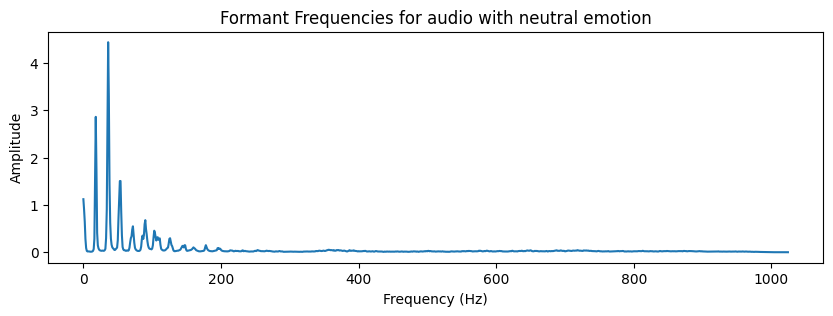

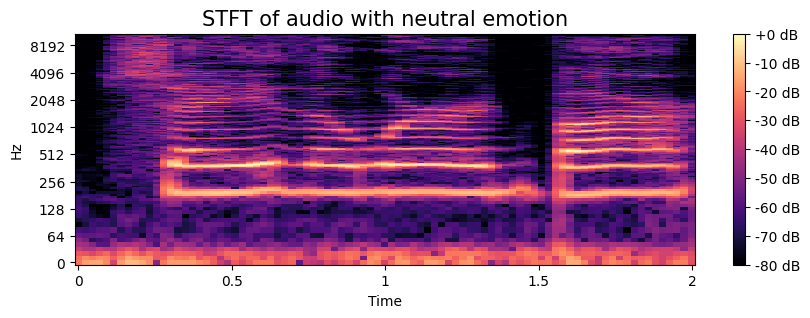

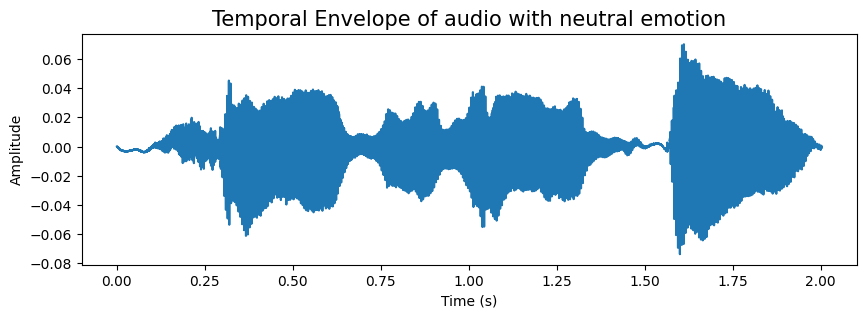

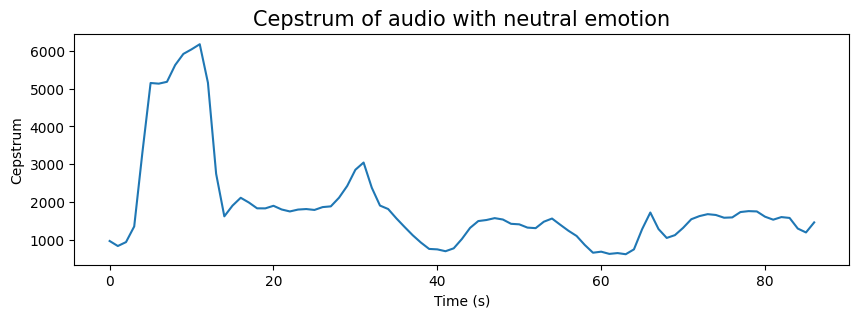

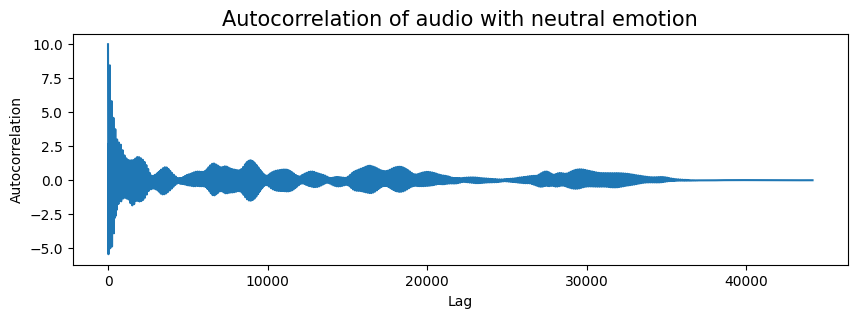

In [21]:
emotion='neutral'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_chroma_features(data, sampling_rate, emotion)
create_tonnetz(data, sampling_rate, emotion)
create_frequency_histogram(data, sampling_rate, emotion)
create_formant_frequencies(data, sampling_rate, emotion)
create_stft_plot(data, sampling_rate, emotion)
create_temporal_envelope(data, sampling_rate, emotion)
create_cepstrum(data, sampling_rate, emotion)
create_autocorrelation(data, sampling_rate, emotion)
Audio(path)

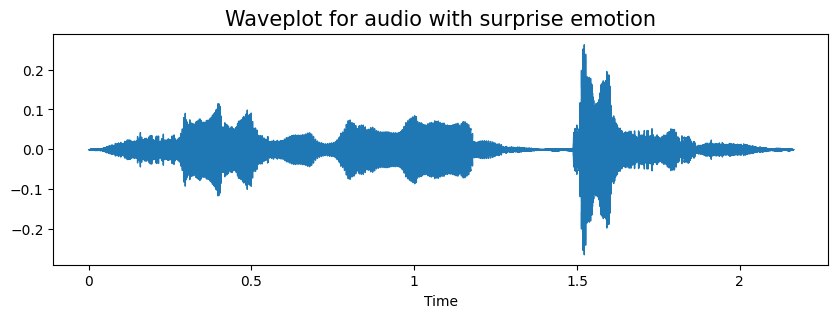

<ipython-input-14-e71bf04b4a12>:10: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


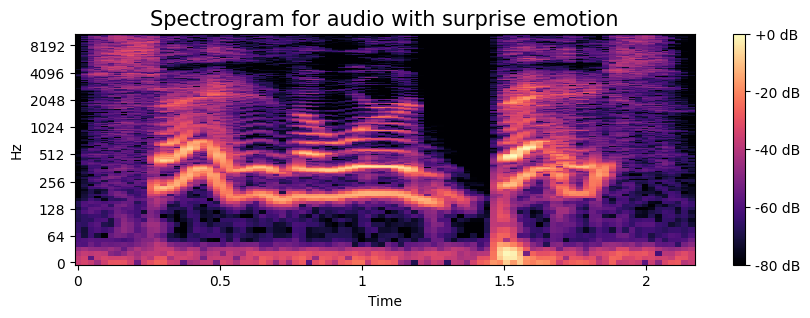

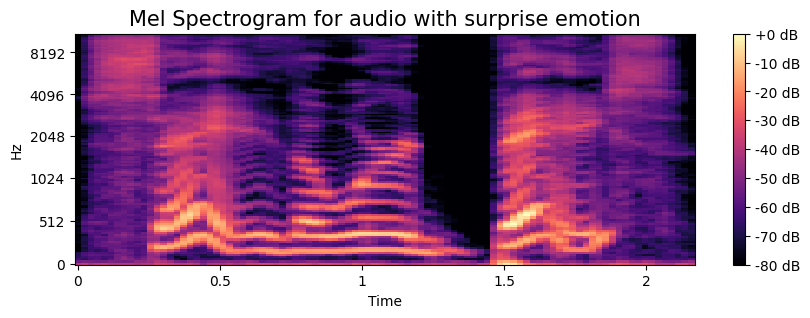

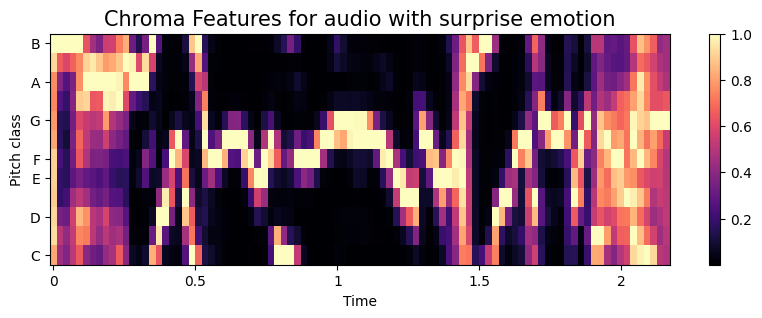

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=746
  warnings.warn(


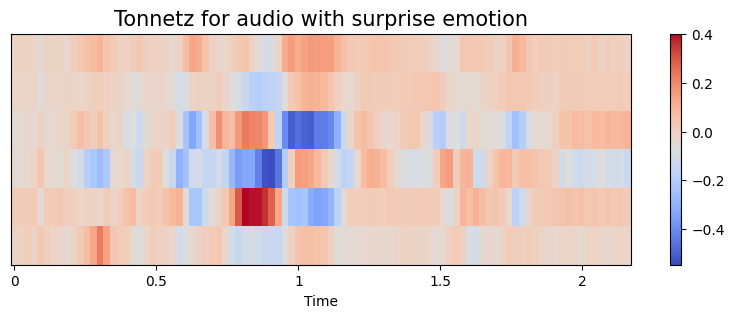

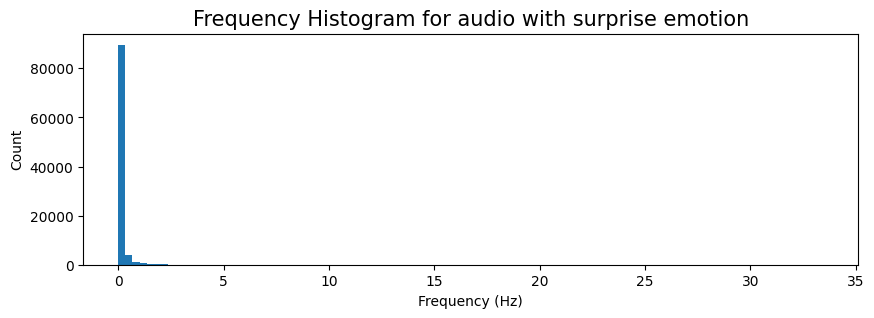

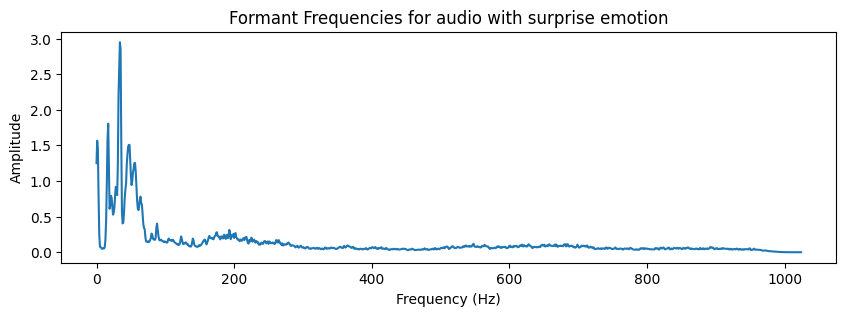

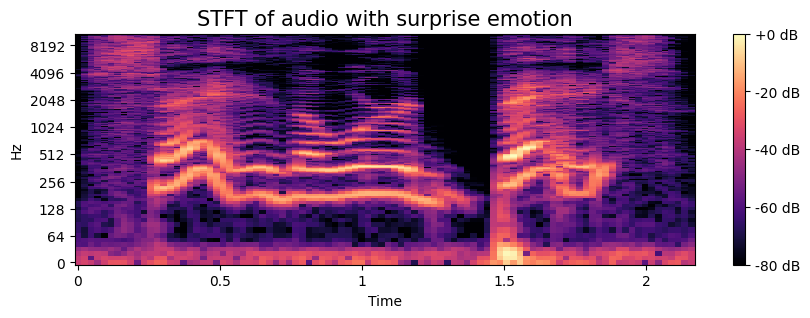

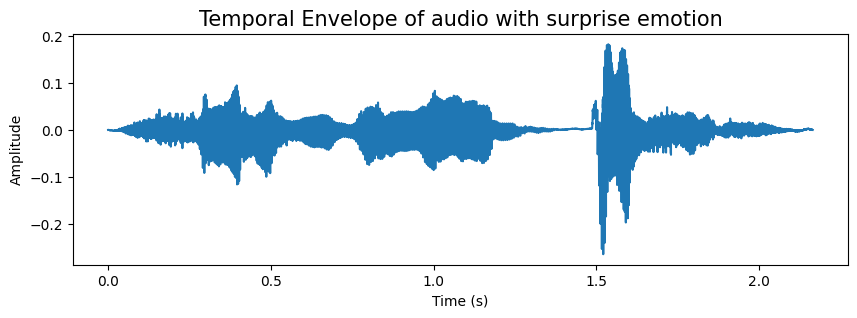

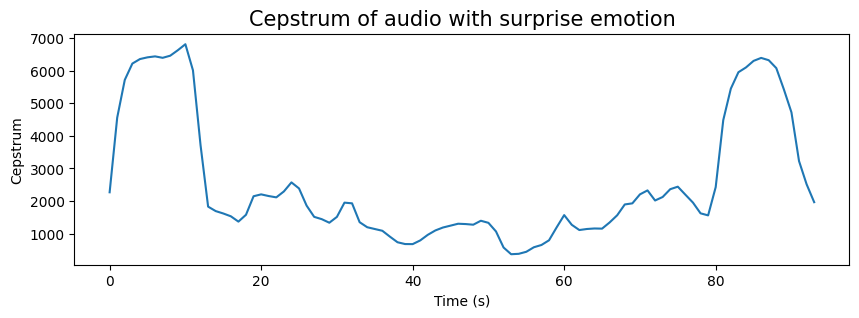

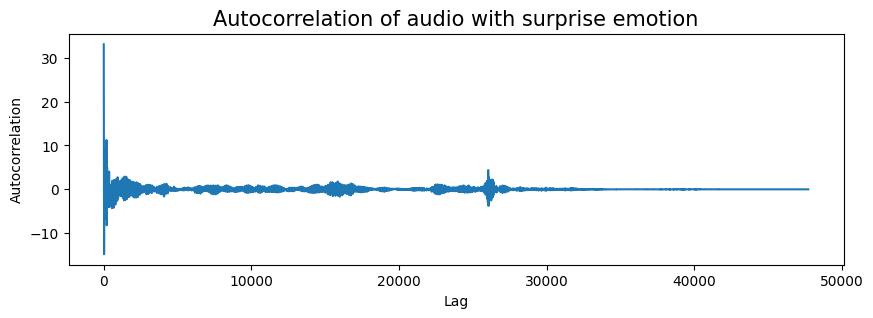

In [22]:
emotion='surprise'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_chroma_features(data, sampling_rate, emotion)
create_tonnetz(data, sampling_rate, emotion)
create_frequency_histogram(data, sampling_rate, emotion)
create_formant_frequencies(data, sampling_rate, emotion)
create_stft_plot(data, sampling_rate, emotion)
create_temporal_envelope(data, sampling_rate, emotion)
create_cepstrum(data, sampling_rate, emotion)
create_autocorrelation(data, sampling_rate, emotion)
Audio(path)

In [23]:
# Define the augmentation functions
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    # Convert pitch_factor to half-steps
    n_steps = pitch_factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)


# Load the example audio file
path = np.array(data_path.Path)[1]  # Select an example file from data_path
data, sample_rate = librosa.load(path)

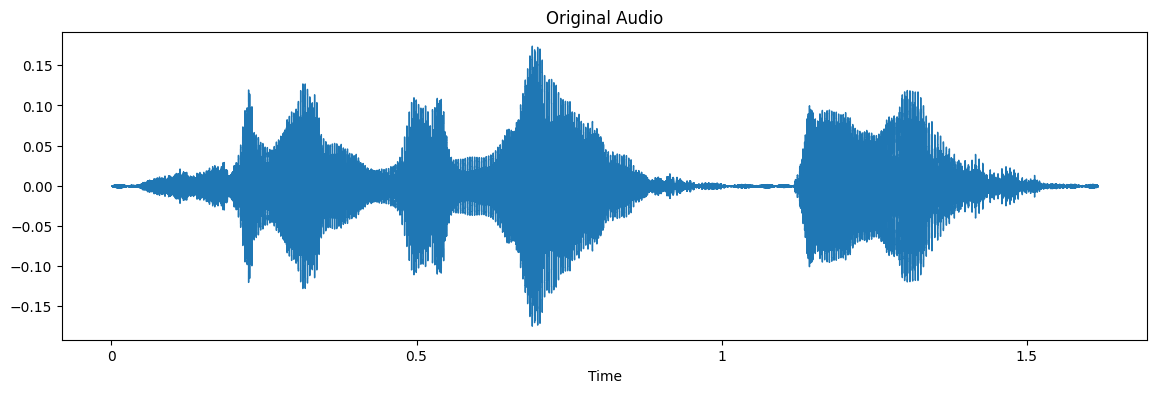

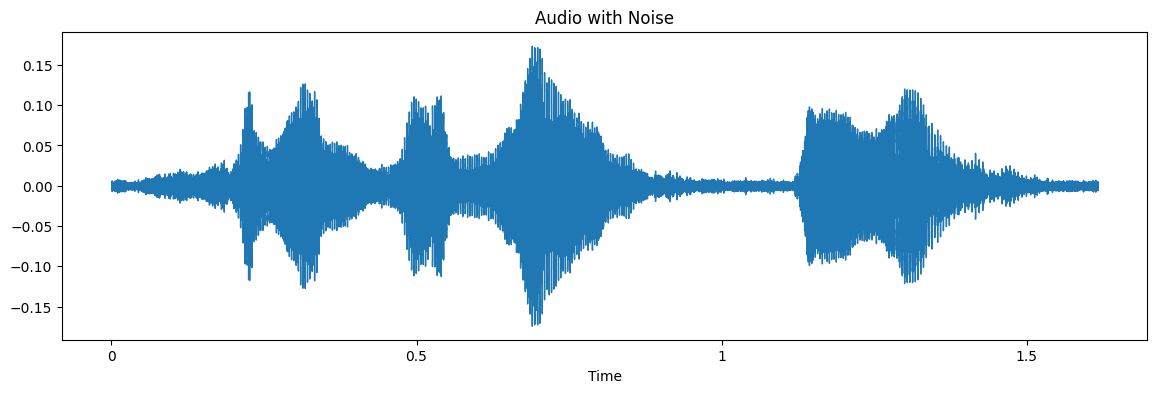

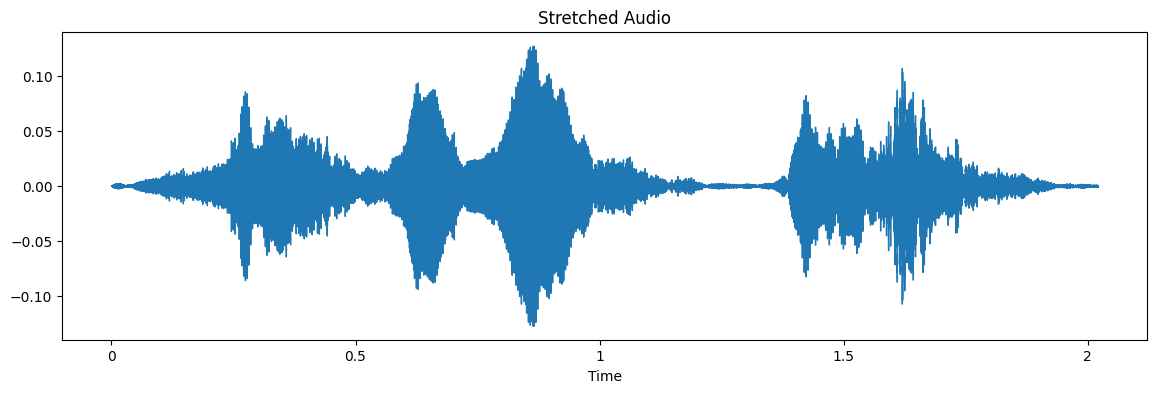

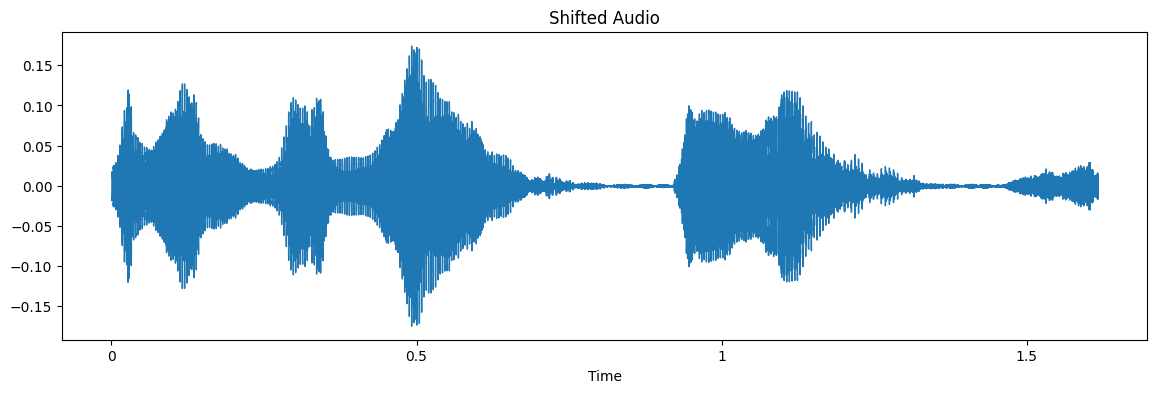

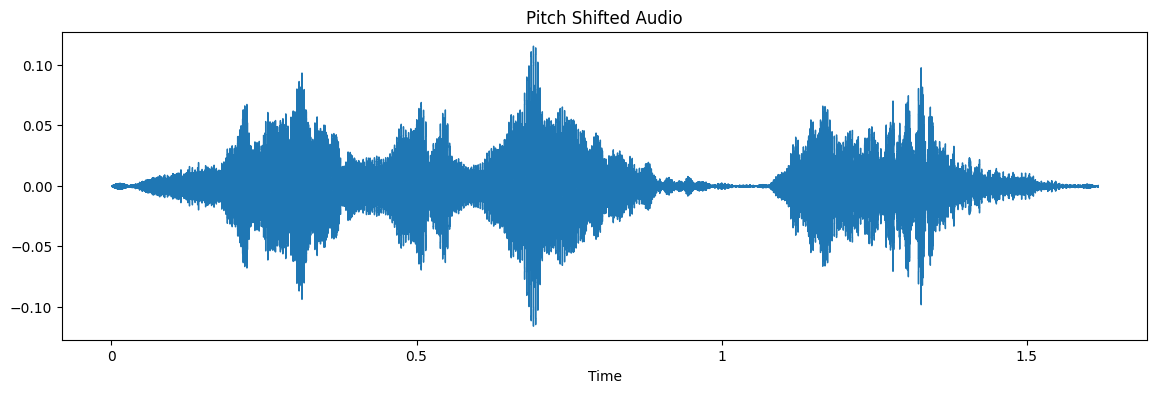

In [24]:
# Plot and play the original audio
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data, sr=sample_rate)
plt.title('Original Audio')
plt.show()
Audio(path)

# Apply noise augmentation and visualize
data_noisy = noise(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data_noisy, sr=sample_rate)
plt.title('Audio with Noise')
plt.show()

# Apply time stretch augmentation and visualize
data_stretched = stretch(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data_stretched, sr=sample_rate)
plt.title('Stretched Audio')
plt.show()

# Apply shifting augmentation and visualize
data_shifted = shift(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data_shifted, sr=sample_rate)
plt.title('Shifted Audio')
plt.show()

# Apply pitch shift augmentation and visualize
data_pitched = pitch(data, sample_rate)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(data_pitched, sr=sample_rate)
plt.title('Pitch Shifted Audio')
plt.show()

# Play the augmented audio (example for noisy audio)
Audio(data_noisy, rate=sample_rate)

In [25]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [26]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [27]:
len(X), len(Y), data_path.Path.shape

(8400, 8400, (2800,))

In [28]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.054342  0.538993  0.596808  0.396304  0.364695  0.441099  0.413557   
1  0.254133  0.724976  0.735588  0.583915  0.584586  0.658709  0.585636   
2  0.073797  0.544300  0.592770  0.374065  0.335807  0.388973  0.397723   
3  0.058006  0.635519  0.406851  0.370775  0.404711  0.507197  0.455434   
4  0.241644  0.828175  0.638426  0.568843  0.580083  0.619627  0.518146   

          7         8         9  ...       153       154       155       156  \
0  0.373404  0.568096  0.573010  ...  0.000105  0.000157  0.000185  0.000133   
1  0.509035  0.676173  0.664123  ...  0.004090  0.004266  0.004328  0.004503   
2  0.296944  0.535104  0.623333  ...  0.000029  0.000026  0.000024  0.000037   
3  0.395454  0.421722  0.353537  ...  0.000115  0.000082  0.000030  0.000011   
4  0.470639  0.524897  0.506033  ...  0.002461  0.002221  0.002138  0.002262   

        157       158       159       160           161  labels  
0  0.000134  0.000070  0.000038  0.000034  6.250610e-06   angry  
1  0.004569  0.004867  0.004405  0.004337  4.438061e-03   angry  
2  0.000041  0.000037  0.000024  0.000007  3.820566e-07   angry  
3  0.000015  0.000021  0.000019  0.000015  9.260876e-07   angry  
4  0.002357  0.002345  0.002099  0.002227  2.204600e-03   angry  

[5 rows x 163 columns]

In [29]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [30]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [31]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [32]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162), (6300, 7), (2100, 162), (2100, 7))

In [33]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 162, 1), (6300, 7), (2100, 162, 1), (2100, 7))

In [34]:
import joblib

# Save the fitted scaler to disk
joblib.dump(scaler, '/content/drive/MyDrive/TESS Toronto emotional speech set data/scaler.pkl')
print("Scaler saved to disk.")
print(scaler.mean_)

Scaler saved to disk.
[ 1.13149213e-01  4.61304747e-01  4.76584090e-01  4.71975921e-01
  4.51117623e-01  4.50017271e-01  4.76467869e-01  5.15970303e-01
  5.11463786e-01  4.77923942e-01  4.62783171e-01  4.55950622e-01
  4.53862375e-01 -4.07947551e+02  7.06565537e+01  6.71595736e+00
  3.53381174e+00 -2.62778197e+00  2.77921730e+00 -5.65728616e+00
 -1.07875089e+01 -7.81784719e+00 -3.53166139e+00 -1.06316503e+01
 -2.54804787e-01 -5.83038885e+00  1.62736436e+00 -2.33762374e+00
 -1.78571530e+00 -1.28944512e+00  1.20906502e+00 -2.98158902e+00
 -5.75260954e-01  2.47901981e-02  2.48696614e-01  2.10932560e-01
  1.39266052e-01  6.13729170e-02  3.52423228e-02  1.82907385e-01
  9.89616749e-01  1.30121229e+00  9.41271355e-01  7.48743919e-01
  1.00824298e+00  1.05661991e+00  8.71128485e-01  1.19384358e+00
  1.29503125e+00  1.20511023e+00  1.27727054e+00  1.38059927e+00
  1.36388809e+00  1.18705497e+00  1.20553748e+00  2.34142248e+00
  3.42423483e+00  1.92802483e+00  8.90266212e-01  6.42182646e-01
  7

In [35]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 162, 256)            │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 81, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 81, 256)             │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 41, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 41, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 21, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 704)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          22,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 557,255 (2.13 MB)

 Trainable params: 557,255 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.3466 - loss: 1.6190 - val_accuracy: 0.7619 - val_loss: 0.7426 - learning_rate: 0.0010
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7425 - loss: 0.7329 - val_accuracy: 0.8871 - val_loss: 0.3453 - learning_rate: 0.0010
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8472 - loss: 0.4634 - val_accuracy: 0.9248 - val_loss: 0.2519 - learning_rate: 0.0010
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8940 - loss: 0.3187 - val_accuracy: 0.9448 - val_loss: 0.1695 - learning_rate: 0.0010
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9215 - loss: 0.2490 - val_accuracy: 0.9605 - val_loss: 0.1233 - learning_rate: 0.0010
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9379 - loss: 0.1931 - val_accuracy: 0.9605 - val_loss: 0.1093 - learning_rate: 0.0010
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9368 - loss: 0.1849 

In [37]:
# Save the model
model_path = '/content/drive/MyDrive/TESS Toronto emotional speech set data/model.keras'
model.save(model_path)
print(f"Model saved at: {model_path}")


Model saved at: /content/drive/MyDrive/TESS Toronto emotional speech set data/model.keras


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.1085
Accuracy of our model on test data :  98.76190423965454 %


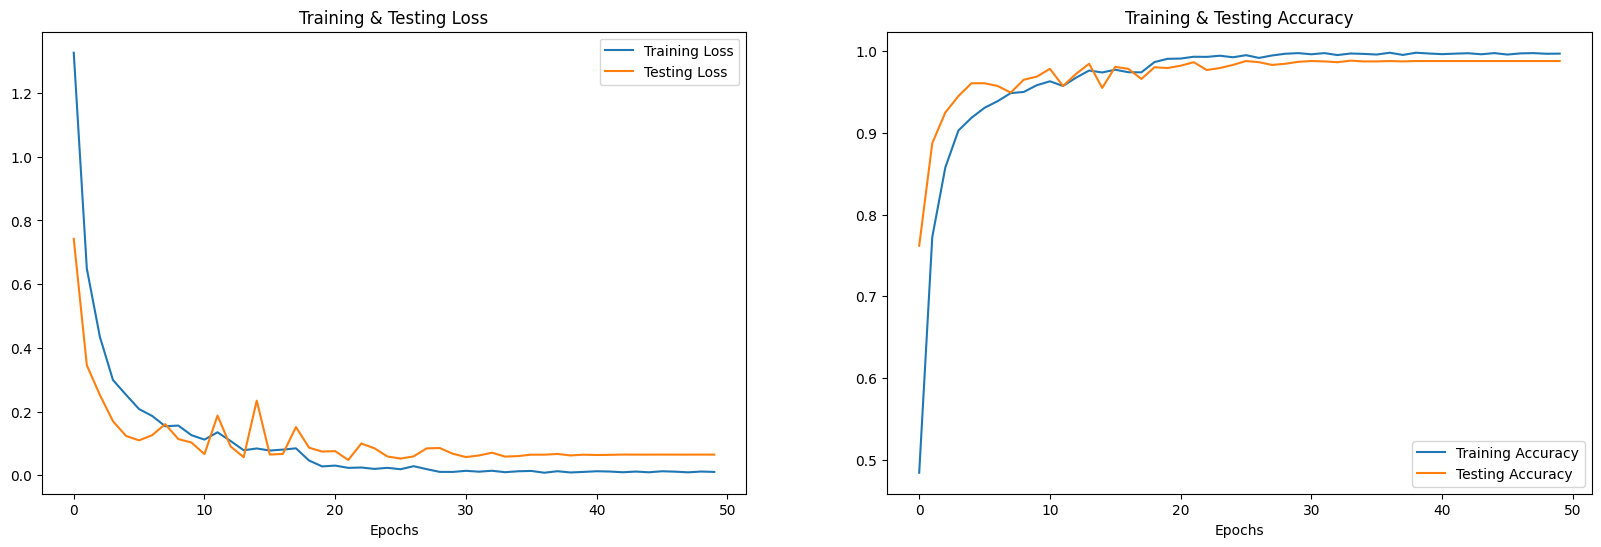

In [38]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [39]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [40]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head()

Predicted Labels Actual Labels
0          neutral       neutral
1            happy      surprise
2          neutral       neutral
3            happy         happy
4         surprise      surprise

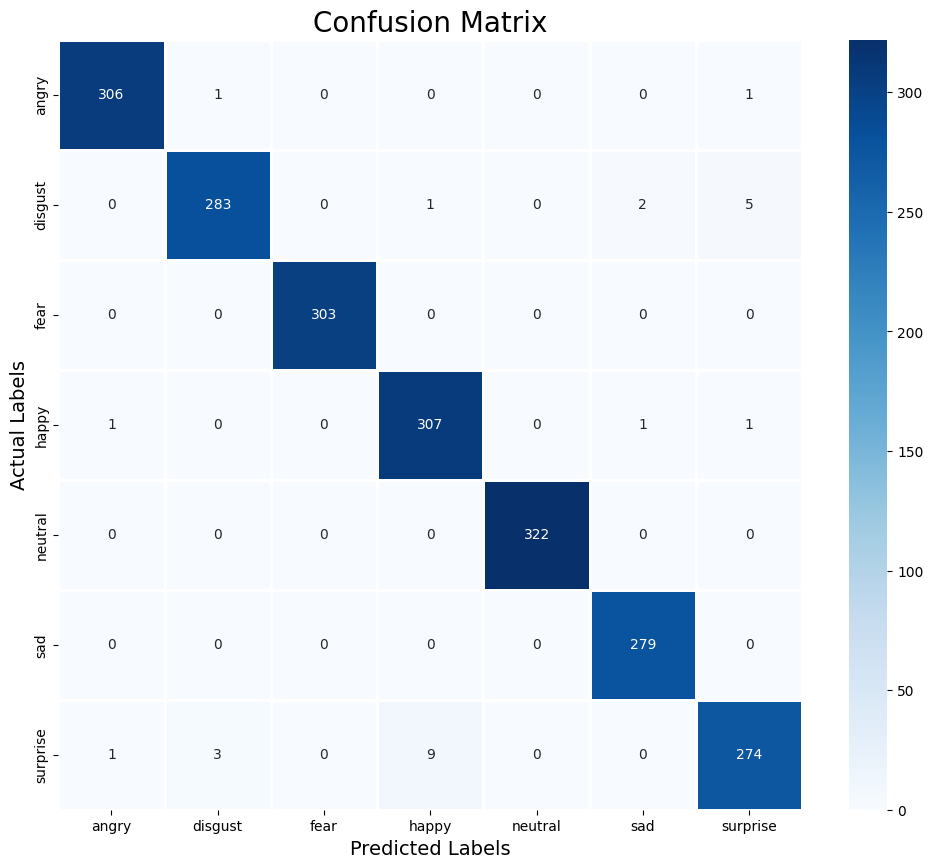

In [41]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [42]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       0.99      0.99      0.99       308
     disgust       0.99      0.97      0.98       291
        fear       1.00      1.00      1.00       303
       happy       0.97      0.99      0.98       310
     neutral       1.00      1.00      1.00       322
         sad       0.99      1.00      0.99       279
    surprise       0.98      0.95      0.96       287

    accuracy                           0.99      2100
   macro avg       0.99      0.99      0.99      2100
weighted avg       0.99      0.99      0.99      2100



In [43]:
import numpy as np
import librosa
import tensorflow as tf
from google.colab import drive
from IPython.display import Audio, display
from google.colab import files
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create directory for audio files if it does not exist
audio_dir = '/content/audio/'
os.makedirs(audio_dir, exist_ok=True)

# Upload the audio file
uploaded = files.upload()
filename = list(uploaded.keys())[0]
file_path = os.path.join(audio_dir, filename)

# Save the uploaded file
with open(file_path, 'wb') as f:
    f.write(uploaded[filename])

print(f"File saved at: {file_path}")

# Define feature extraction function
def extract_features(data, sample_rate):
    result = np.array([])

    # Zero-Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma-stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

def preprocess_and_extract_features(file_path):
    data, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)

    # Feature extraction
    features = extract_features(data, sample_rate)

    # Feature normalization (e.g., min-max scaling)
    features = (features - np.min(features)) / (np.max(features) - np.min(features))

    # Reshape for model input
    features = np.expand_dims(features, axis=0)
    features = np.expand_dims(features, axis=2)

    return features

# Load your pre-trained model

model_path = '/content/drive/MyDrive/TESS Toronto emotional speech set data/model.keras'
model = tf.keras.models.load_model(model_path)


# Extract features from the uploaded audio file
features = preprocess_and_extract_features(file_path)

# Make predictions
predictions = model.predict(features)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)

# Define emotion labels mapping (ensure this matches your model's training labels)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Convert predicted class index to emotion label
if predicted_class_index[0] < len(emotion_labels):
    predicted_emotion = emotion_labels[predicted_class_index[0]]
else:
    print(f"Predicted class index {predicted_class_index[0]} is out of range for emotion labels.")
    predicted_emotion = "Unknown"

print(f"Predicted Emotion Class: {predicted_emotion}")

# Play the uploaded audio file
print(f"Playing {filename}:")
display(Audio(file_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving YAF_voice_happy.wav to YAF_voice_happy.wav
File saved at: /content/audio/YAF_voice_happy.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Emotion Class: disgust
Playing YAF_voice_happy.wav:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


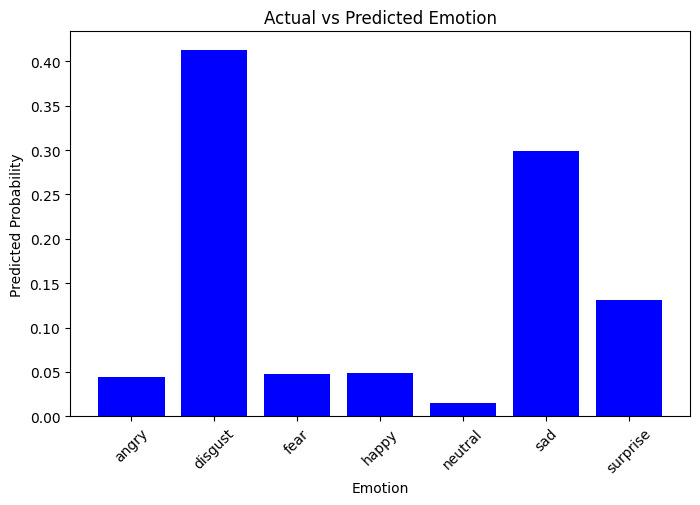

Predicted Emotion: disgust


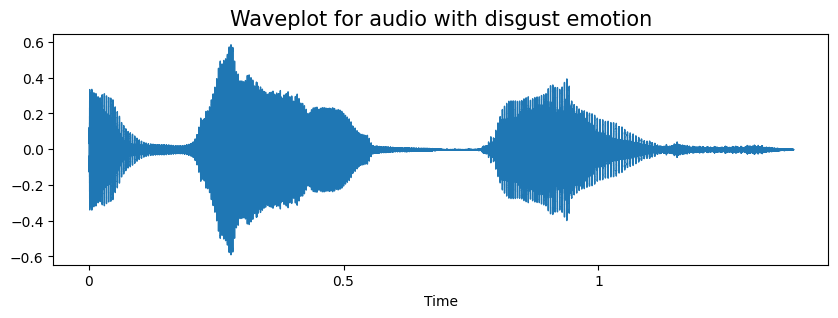

<ipython-input-44-aa634e4d68bb>:48: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)


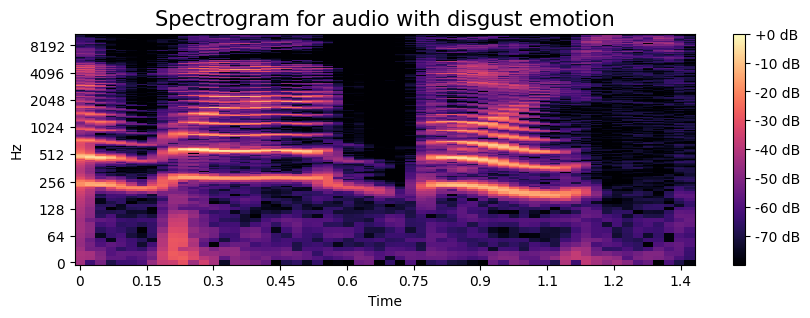

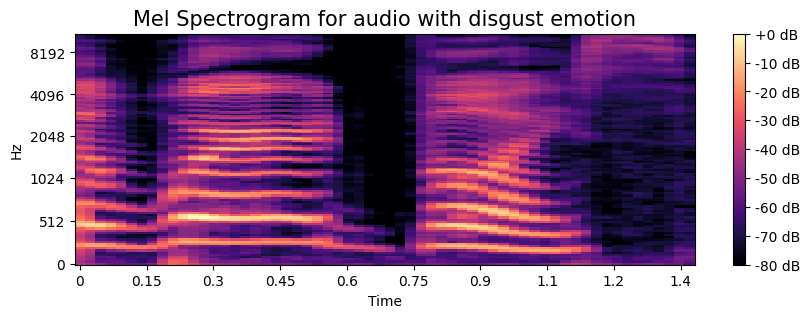

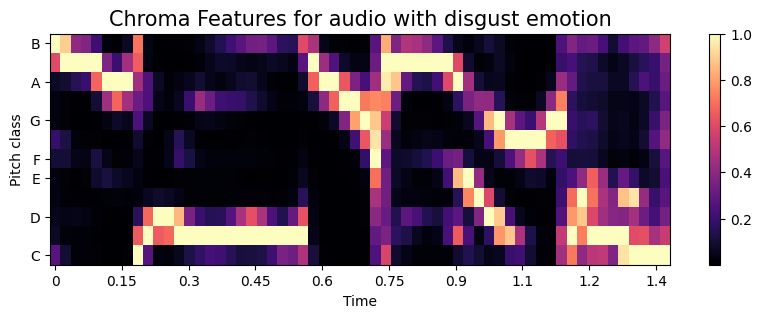

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=953
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=477
  warnings.warn(


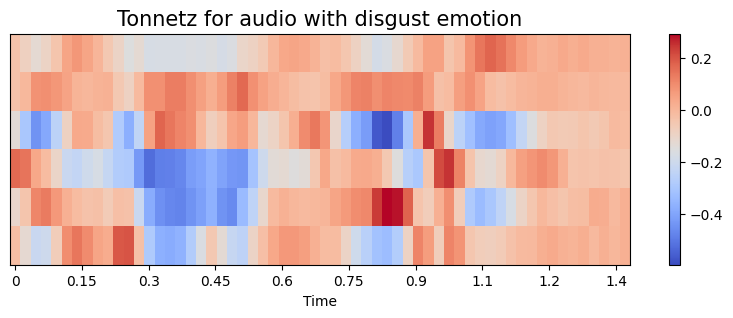

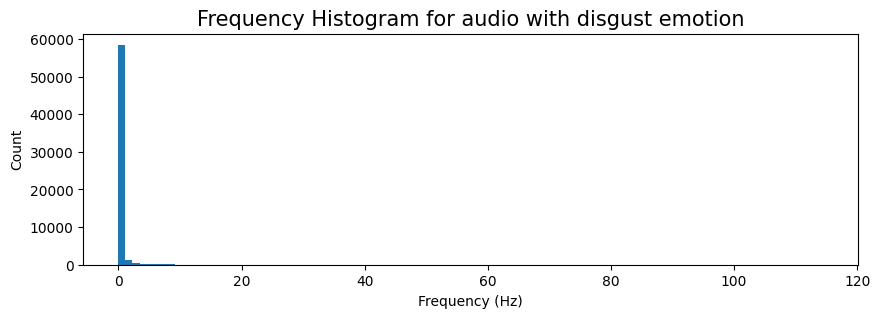

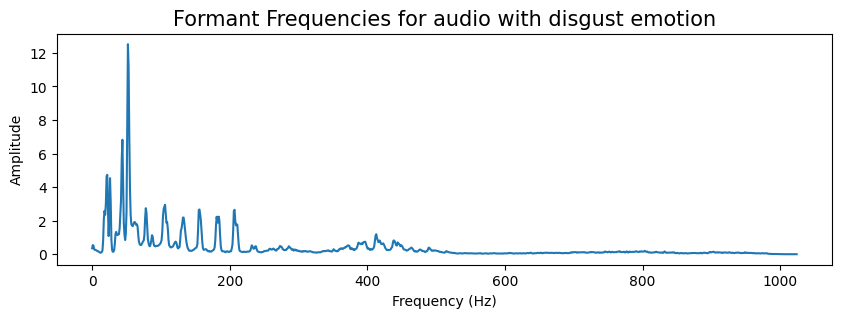

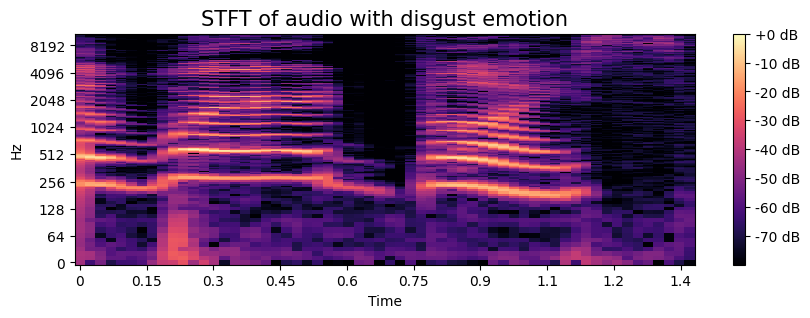

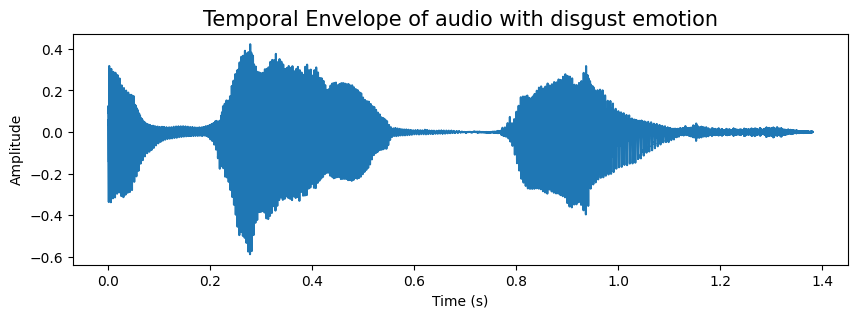

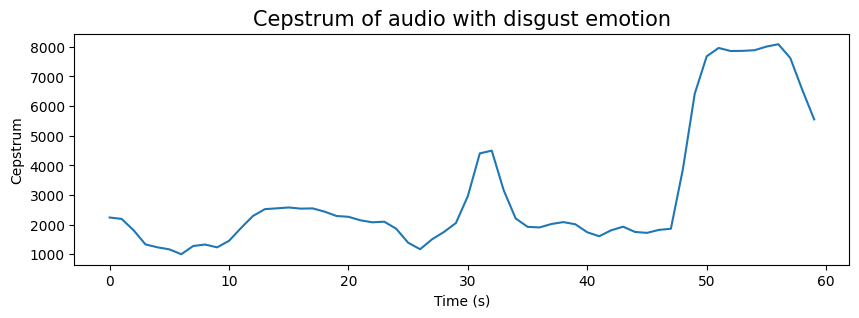

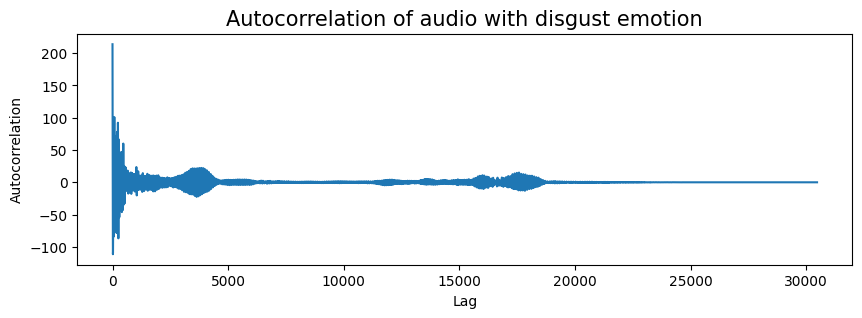

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot actual vs predicted emotions
def plot_actual_vs_predicted(actual, predicted):
    plt.figure(figsize=(8, 5))
    plt.bar(actual, predicted, color='blue')
    plt.xlabel('Emotion')
    plt.ylabel('Predicted Probability')
    plt.title('Actual vs Predicted Emotion')
    plt.xticks(rotation=45)
    plt.show()

# Extracted features
features = preprocess_and_extract_features(file_path)

# Make predictions
predictions = model.predict(features)

# Get the predicted class index and probabilities
predicted_class_index = np.argmax(predictions, axis=1)
predicted_probabilities = predictions[0]

# Define emotion labels mapping (ensure this matches your model's training labels)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Plot predicted probabilities for each emotion
plot_actual_vs_predicted(emotion_labels, predicted_probabilities)

# Convert predicted class index to emotion label
predicted_emotion = emotion_labels[predicted_class_index[0]]
print(f"Predicted Emotion: {predicted_emotion}")

# Load the audio for visualization
data, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)

# Ensure all functions are defined correctly, including create_mel_spectrogram
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)

    plt.show()

def create_spectrogram(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)
    D = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def create_mel_spectrogram(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Mel Spectrogram for audio with {e} emotion', size=15)
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def create_chroma_features(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Chroma Features for audio with {e} emotion', size=15)
    chroma = librosa.feature.chroma_stft(y=data, sr=sr)
    librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
    plt.colorbar()
    plt.show()

def create_tonnetz(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Tonnetz for audio with {e} emotion', size=15)
    tonnetz = librosa.feature.tonnetz(y=data, sr=sr)
    librosa.display.specshow(tonnetz, x_axis='time')
    plt.colorbar()
    plt.show()

def create_frequency_histogram(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Frequency Histogram for audio with {e} emotion', size=15)
    spectrum = np.abs(librosa.stft(data))
    plt.hist(spectrum.flatten(), bins=100)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Count')
    plt.show()

def create_formant_frequencies(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Formant Frequencies for audio with {e} emotion', size=15)
    spectrum = np.abs(librosa.stft(data))
    mean_spectrum = np.mean(spectrum, axis=1)
    plt.plot(mean_spectrum)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.show()

def create_stft_plot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'STFT of audio with {e} emotion', size=15)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

def create_temporal_envelope(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Temporal Envelope of audio with {e} emotion', size=15)
    plt.plot(np.linspace(0, len(data)/sr, num=len(data)), data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_cepstrum(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Cepstrum of audio with {e} emotion', size=15)
    ceps = librosa.feature.spectral_centroid(y=data, sr=sr)
    plt.plot(ceps.T)
    plt.xlabel('Time (s)')
    plt.ylabel('Cepstrum')
    plt.show()

def create_autocorrelation(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Autocorrelation of audio with {e} emotion', size=15)
    autocorr = librosa.autocorrelate(data)
    plt.plot(autocorr)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

# You can call the functions as before after making predictions and extracting features
create_waveplot(data, sample_rate, predicted_emotion)
create_spectrogram(data, sample_rate, predicted_emotion)
create_mel_spectrogram(data, sample_rate, predicted_emotion)
create_chroma_features(data, sample_rate, predicted_emotion)
create_tonnetz(data, sample_rate, predicted_emotion)
create_frequency_histogram(data, sample_rate, predicted_emotion)
create_formant_frequencies(data, sample_rate, predicted_emotion)
create_stft_plot(data, sample_rate, predicted_emotion)
create_temporal_envelope(data, sample_rate, predicted_emotion)
create_cepstrum(data, sample_rate, predicted_emotion)
create_autocorrelation(data, sample_rate, predicted_emotion)

